In [3]:
import pandas as pd
import numpy as np
import ast
import itertools

import seaborn as sns
import matplotlib.pyplot as plt


### Loading Data

In [4]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [5]:
fix_A_path = "full/fixations_A.csv"
df_fix_A = pd.read_csv(fix_A_path)

C:\Users\deeth\AppData\Local\Temp\ipykernel_26888\878136727.py:2: DtypeWarning: Columns (37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fix_A = pd.read_csv(fix_A_path)


### Data Preprocessing

In [6]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'
q_ind = 'same_critical_span'

df_A_filtered['text_id'] = (
    df_A_filtered[article_col].astype(str) + '_' +
    df_A_filtered[difficulty_col].astype(str) + '_' +
    df_A_filtered[batch_col].astype(str) + '_' +
    df_A_filtered[paragraph_col].astype(str) + '_' +
    df_A_filtered[q_ind].astype(str)
    )

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True].copy()
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False].copy()

C:\Users\deeth\AppData\Local\Temp\ipykernel_26888\1610736497.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A_filtered['text_id'] = (


In [7]:
df_fix_filtered = df_fix_A[(df_fix_A['repeated_reading_trial'] == False) & ((df_fix_A['practice_trial'] == False))]

df_fix_hunters = df_fix_filtered[df_fix_filtered['question_preview'] == True].copy()
df_fix_gatherers = df_fix_filtered[df_fix_filtered['question_preview'] == False].copy()

In [8]:
def get_fix_columns(df):
    df_fix = (
        df
        .groupby(['participant_id', 'TRIAL_INDEX'], sort=False)
        .agg({
            'CURRENT_FIX_INTEREST_AREA_INDEX': lambda x: tuple(x),
            'CURRENT_FIX_DURATION':             lambda x: tuple(x),
            'CURRENT_FIX_X':                    lambda x: tuple(x),
            'CURRENT_FIX_Y':                    lambda x: tuple(x),
        })
        .reset_index()
        .rename(columns={
            'CURRENT_FIX_INTEREST_AREA_INDEX': 'fix_seq',
            'CURRENT_FIX_DURATION':            'fix_duration',
            'CURRENT_FIX_X':                   'fix_x',
            'CURRENT_FIX_Y':                   'fix_y',
        })
    )

    #collapse consecutive duplicates: sum durations, avg coords
    def collapse_runs(seq, durations, xs, ys):
        short_seq = []
        short_durs = []
        avg_xs = []
        avg_ys = []

        for fixation, group in itertools.groupby(
            zip(seq, durations, xs, ys),
            key=lambda t: t[0]
        ):
            run = list(group)
            total_dur = sum(item[1] for item in run)
            mean_x = sum(item[2] for item in run) / len(run)
            mean_y = sum(item[3] for item in run) / len(run)

            short_seq.append(fixation)
            short_durs.append(total_dur)
            avg_xs.append(mean_x)
            avg_ys.append(mean_y)

        return (
            tuple(short_seq),
            tuple(short_durs),
            tuple(avg_xs),
            tuple(avg_ys),
        )

    df_fix[['short_fix_seq',
            'short_fix_duration',
            'short_fix_x',
            'short_fix_y']] = (
        df_fix
        .apply(lambda row: pd.Series(
            collapse_runs(
                row['fix_seq'],
                row['fix_duration'],
                row['fix_x'],
                row['fix_y'],
            )
        ), axis=1)
    )

    return df_fix

In [9]:
df_h_fix = get_fix_columns(df_fix_hunters)
df_g_fix = get_fix_columns(df_fix_gatherers)

In [10]:
df_h_fix

,participant_id,TRIAL_INDEX,fix_seq,fix_duration,fix_x,fix_y,short_fix_seq,short_fix_duration,short_fix_x,short_fix_y
0,l42_2070,4,"(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(501.8, 997.5, 1271.4, 1395.7, 1109.3, 1907.3,...","(196.9, 461.3, 400.0, 399.4, 403.4, 828.7, 909...","(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(501.8, 997.5, 1271.4, 1395.7, 1109.3, 1907.3,...","(196.9, 461.3, 400.0, 399.4, 403.4, 828.7, 909..."
1,l42_2070,5,"(0, 12, 11, 13, 18, 11, 13, 12, 13, 12, 26, 28...","(224, 178, 137, 185, 399, 178, 211, 245, 217, ...","(693.0, 1132.2, 1099.4, 1384.3, 1158.9, 1086.5...","(256.8, 463.4, 429.7, 414.3, 511.4, 416.7, 414...","(0, 12, 11, 13, 18, 11, 13, 12, 13, 12, 26, 28...","(224, 178, 137, 185, 399, 178, 211, 245, 217, ...","(693.0, 1132.2, 1099.4, 1384.3, 1158.9, 1086.5...","(256.8, 463.4, 429.7, 414.3, 511.4, 416.7, 414..."
2,l42_2070,6,"(5, 14, 17, 17, 21, 14, 16, 18, 27, 31, 30, 34...","(155, 154, 204, 196, 261, 190, 123, 138, 151, ...","(935.9, 1005.2, 1374.8, 1451.6, 1127.0, 1054.8...","(248.7, 467.2, 408.0, 411.2, 546.2, 449.5, 426...","(5, 14, 17, 21, 14, 16, 18, 27, 31, 30, 34, 31...","(155, 154, 400, 261, 190, 123, 138, 151, 177, ...","(935.9, 1005.2, 1413.1999999999998, 1127.0, 10...","(248.7, 467.2, 409.6, 546.2, 449.5, 426.0, 412..."
3,l42_2070,7,"(4, 8, 10, 11, 24, 19, 35, 27, 33, 14, 14, 0, ...","(142, 178, 151, 78, 181, 246, 146, 223, 28, 32...","(650.4, 1099.4, 1317.6, 1420.0, 1967.0, 2152.2...","(197.0, 443.4, 427.9, 425.5, 860.3, 822.8, 119...","(4, 8, 10, 11, 24, 19, 35, 27, 33, 14, 0, 10, ...","(142, 178, 151, 78, 181, 246, 146, 223, 28, 46...","(650.4, 1099.4, 1317.6, 1420.0, 1967.0, 2152.2...","(197.0, 443.4, 427.9, 425.5, 860.3, 822.8, 119..."
4,l42_2070,8,"(3, 9, 12, 11, 17, 31, 33, 0, 42, 31, 29, 36, ...","(217, 151, 166, 161, 193, 186, 234, 127, 52, 1...","(657.0, 1123.6, 1370.7, 1284.1, 1237.1, 1985.1...","(192.0, 396.8, 423.0, 434.2, 544.1, 824.0, 807...","(3, 9, 12, 11, 17, 31, 33, 0, 42, 31, 29, 36, ...","(217, 151, 166, 161, 193, 186, 234, 127, 52, 1...","(657.0, 1123.6, 1370.7, 1284.1, 1237.1, 1985.1...","(192.0, 396.8, 423.0, 434.2, 544.1, 824.0, 807..."
...,...,...,...,...,...,...,...,...,...,...
9715,l10_39,55,"(2, 0, 6, 8, 11, 24, 11, 6, 7, 11, 14, 18, 20,...","(177, 115, 173, 147, 34, 284, 128, 201, 128, 1...","(498.0, 937.5, 1131.7, 1384.7, 1024.7, 472.4, ...","(230.4, 364.2, 429.6, 434.6, 580.3, 758.7, 495...","(2, 0, 6, 8, 11, 24, 11, 6, 7, 11, 14, 18, 20,...","(177, 115, 173, 147, 34, 284, 128, 201, 128, 1...","(498.0, 937.5, 1131.7, 1384.7, 1024.7, 472.4, ...","(230.4, 364.2, 429.6, 434.6, 580.3, 758.7, 495..."
9716,l10_39,56,"(1, 0, 7, 10, 14, 0, 31, 31, 33, 35, 37, 41, 4...","(33, 74, 161, 139, 279, 129, 208, 157, 78, 173...","(407.6, 809.9, 1063.4, 1311.1, 1091.4, 1782.9,...","(226.5, 374.1, 465.6, 435.1, 542.1, 678.9, 758...","(1, 0, 7, 10, 14, 0, 31, 33, 35, 37, 41, 45, 4...","(33, 74, 161, 139, 279, 129, 365, 78, 173, 176...","(407.6, 809.9, 1063.4, 1311.1, 1091.4, 1782.9,...","(226.5, 374.1, 465.6, 435.1, 542.1, 678.9, 775..."
9717,l10_39,57,"(4, 8, 9, 12, 16, 11, 12, 16, 0, 28, 31, 35, 3...","(63, 115, 182, 250, 239, 120, 90, 241, 126, 17...","(782.0, 997.8, 1181.1, 1424.3, 1123.8, 1281.5,...","(235.8, 416.2, 468.0, 451.8, 547.7, 447.7, 419...","(4, 8, 9, 12, 16, 11, 12, 16, 0, 28, 31, 35, 3...","(63, 115, 182, 250, 239, 120, 90, 241, 126, 17...","(782.0, 997.8, 1181.1, 1424.3, 1123.8, 1281.5,...","(235.8, 416.2, 468.0, 451.8, 547.7, 447.7, 419..."
9718,l10_39,58,"(17, 0, 18, 20, 0, 25, 22, 25, 0, 0)","(39, 136, 134, 192, 211, 386, 272, 269, 123, 13)","(398.2, 955.6, 996.5, 293.2, 1705.7, 1093.3, 1...","(294.0, 574.7, 457.1, 805.1, 828.3, 1094.2, 75...","(17, 0, 18, 20, 0, 25, 22, 25, 0)","(39, 136, 134, 192, 211, 386, 272, 269, 136)","(398.2, 955.6, 996.5, 293.2, 1705.7, 1093.3, 1...","(294.0, 574.7, 457.1, 805.1, 828.3, 1094.2, 75..."


In [11]:
df_A_hunters = df_A_hunters.merge(df_h_fix, on=['TRIAL_INDEX', 'participant_id'], how='left')
df_A_gatherers = df_A_gatherers.merge(df_g_fix, on=['TRIAL_INDEX', 'participant_id'], how='left')

### Creating Features

In [12]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [13]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [14]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [15]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_area_screen_loc,
    create_area_label,
    create_selected_answer_label
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_area_screen_loc at 0x00000230EAC06B90>
<function create_area_label at 0x000002311F6AFD90>
<function create_selected_answer_label at 0x00000230EAC06CB0>
<function create_area_screen_loc at 0x00000230EAC06B90>
<function create_area_label at 0x000002311F6AFD90>
<function create_selected_answer_label at 0x00000230EAC06CB0>


In [16]:
def create_fixation_sequence_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        label_sequence = []
        location_sequence = []

        for ia_id in sequence:
            if ia_id in group_ids:
                label_sequence.append(id_to_label[ia_id])
                location_sequence.append(id_to_location[ia_id])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': tuple(label_sequence[1:]),
            'fix_by_loc': tuple(location_sequence[1:])
        })

    return pd.DataFrame(result)

In [17]:
def create_simplified_fixation_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        durations = group['short_fix_duration'].iloc[0]
        xs        = group['short_fix_x'].iat[0]
        ys        = group['short_fix_y'].iat[0]

        valid_fixations = []
        for ia_id, dur, x, y in zip(sequence, durations, xs, ys):
            if ia_id in group_ids:
                valid_fixations.append((
                    ia_id,
                    id_to_label[ia_id],
                    id_to_location[ia_id],
                    dur,
                    x,
                    y
                ))

        simpl_labels    = []
        simpl_locations = []
        simpl_durations = []
        simpl_xs        = []
        simpl_ys        = []

        for label, run in itertools.groupby(valid_fixations, key=lambda item: item[1]):
            run_list = list(run)
            simpl_labels.append(label)
            simpl_locations.append(run_list[0][2])
            simpl_durations.append(sum(item[3] for item in run_list))
            simpl_xs.append(sum(item[4] for item in run_list) / len(run_list))
            simpl_ys.append(sum(item[5] for item in run_list) / len(run_list))

        result.append({
            'TRIAL_INDEX':       trial_index,
            'participant_id':    participant_id,
            'simpl_fix_by_label':    tuple(simpl_labels[1:]),
            'simpl_fix_by_loc':      tuple(simpl_locations[1:]),
            'simpl_fix_duration':    tuple(simpl_durations[1:]),
            'simpl_fix_x':           tuple(simpl_xs[1:]),
            'simpl_fix_y':           tuple(simpl_ys[1:])
        })
    return pd.DataFrame(result)

In [18]:
def first_visits_ordered(df):
    df = df.copy()

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        seen = set()
        label_seq = []
        loc_seq = []
        for labels, screen_locs in zip(group['fix_by_label'], group['fix_by_loc']):
            for label, screen_loc in zip(labels, screen_locs):
                if (label, screen_loc) not in seen:
                    seen.add((label, screen_loc))
                    label_seq.append(label)
                    loc_seq.append(screen_loc)
        label_seq = tuple(label_seq)
        loc_seq = tuple(loc_seq)
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'first_visits_area_label': label_seq,
            'first_visits_area_screen_loc': loc_seq
        })
    df_first_visits = pd.DataFrame(result)
    return df_first_visits

In [19]:
def last_visits_ordered(df):
    df = df.copy()

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        seen = set()
        label_seq = []
        loc_seq = []
        for labels, screen_locs in zip(group.iloc[::-1]['fix_by_label'], group.iloc[::-1]['fix_by_loc']):
            i = 0
            for label, screen_loc in zip(reversed(labels), reversed(screen_locs)):
                i = i +1
                if (label, screen_loc) not in seen:
                    seen.add((label, screen_loc))
                    label_seq.append(label)
                    loc_seq.append(screen_loc)
        label_seq = tuple(label_seq[::-1])
        loc_seq = tuple(loc_seq[::-1])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'last_visits_area_label': label_seq,
            'last_visits_area_screen_loc': loc_seq
        })
    df_first_visits = pd.DataFrame(result)
    return df_first_visits

In [20]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(result_df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [21]:
per_row_feature_generators = [
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_simplified_fixation_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (first_visits_ordered, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (last_visits_ordered, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
]

In [22]:
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_fixation_sequence_tags at 0x00000233B687FEB0>
<function create_simplified_fixation_tags at 0x00000233AEC52F80>
<function first_visits_ordered at 0x0000022FD0081C60>
<function last_visits_ordered at 0x00000233AEC52710>
<function create_fixation_sequence_tags at 0x00000233B687FEB0>
<function create_simplified_fixation_tags at 0x00000233AEC52F80>
<function first_visits_ordered at 0x0000022FD0081C60>
<function last_visits_ordered at 0x00000233AEC52710>


#### No questions version

In [23]:
def remove_questions(df,
                     source_col='first_visits_area_label',
                     target_col='first_vis_no_q'):
    df[target_col] = df[source_col].apply(
        lambda lst: tuple(item for item in lst if item != 'question')
    )
    return df

In [24]:
df_with_features_h = remove_questions(df_with_features_h, source_col='first_visits_area_screen_loc', target_col='first_vis_loc_no_q').copy()
df_with_features_g = remove_questions(df_with_features_g, source_col='first_visits_area_screen_loc', target_col='first_vis_loc_no_q').copy()

df_with_features_h = remove_questions(df_with_features_h, source_col='first_visits_area_label', target_col='first_vis_lb_no_q').copy()
df_with_features_g = remove_questions(df_with_features_g, source_col='first_visits_area_label', target_col='first_vis_lb_no_q').copy()

In [35]:
df_with_features_h = remove_questions(df_with_features_h, source_col='last_visits_area_screen_loc', target_col='last_vis_loc_no_q').copy()
df_with_features_g = remove_questions(df_with_features_g, source_col='last_visits_area_screen_loc', target_col='last_vis_loc_no_q').copy()

df_with_features_h = remove_questions(df_with_features_h, source_col='last_visits_area_label', target_col='last_vis_lb_no_q').copy()
df_with_features_g = remove_questions(df_with_features_g, source_col='last_visits_area_label', target_col='last_vis_lb_no_q').copy()

### Starts Frequencies Graphs


In [46]:
def plot_freq_hist(df, column='first_visits_area_screen_loc', top_n=None, figsize=(15,6), h_or_g = 'undefined', ans = '?'):
    counts = df[column].value_counts(dropna=False)

    if top_n is not None:
        counts = counts.head(top_n)

    plt.figure(figsize=figsize)
    counts.plot(kind='bar')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.title(f'hist_{column}_top-{top_n}_{h_or_g}_answered_{ans}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"plots/visits_hists/hist_{column}_top-{top_n}_{h_or_g}_answered_{ans}.png")
    plt.show()

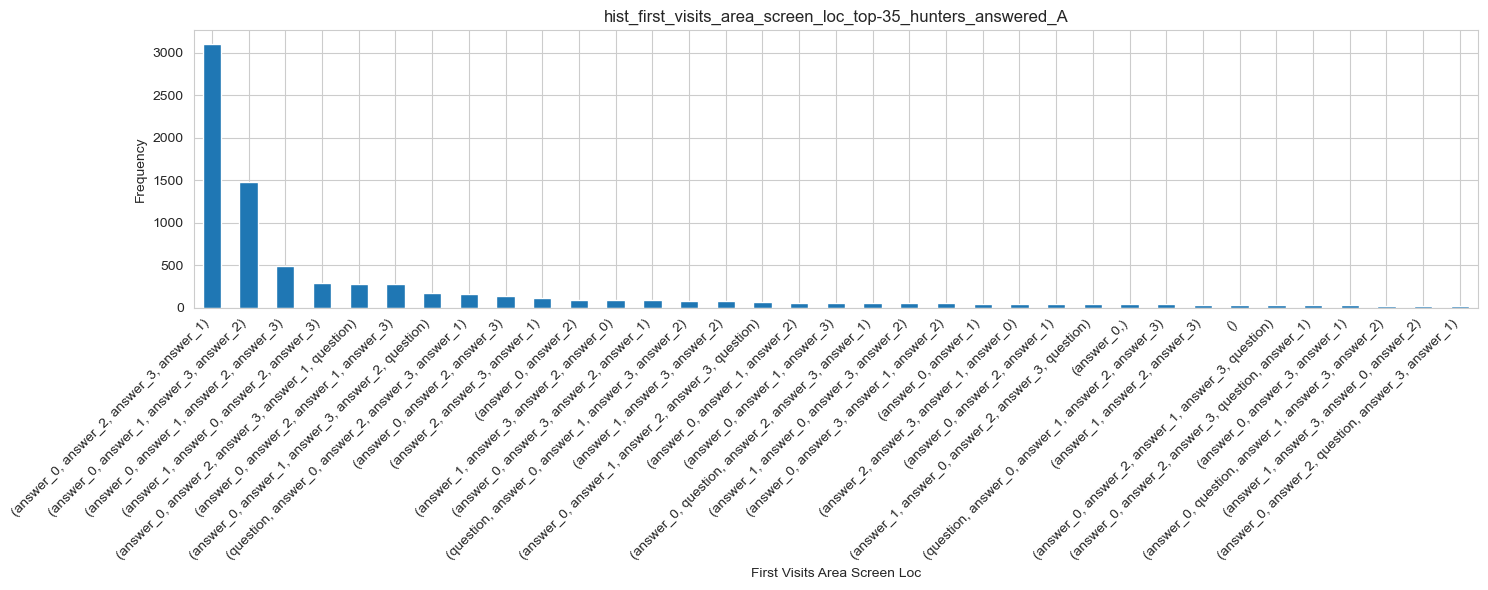

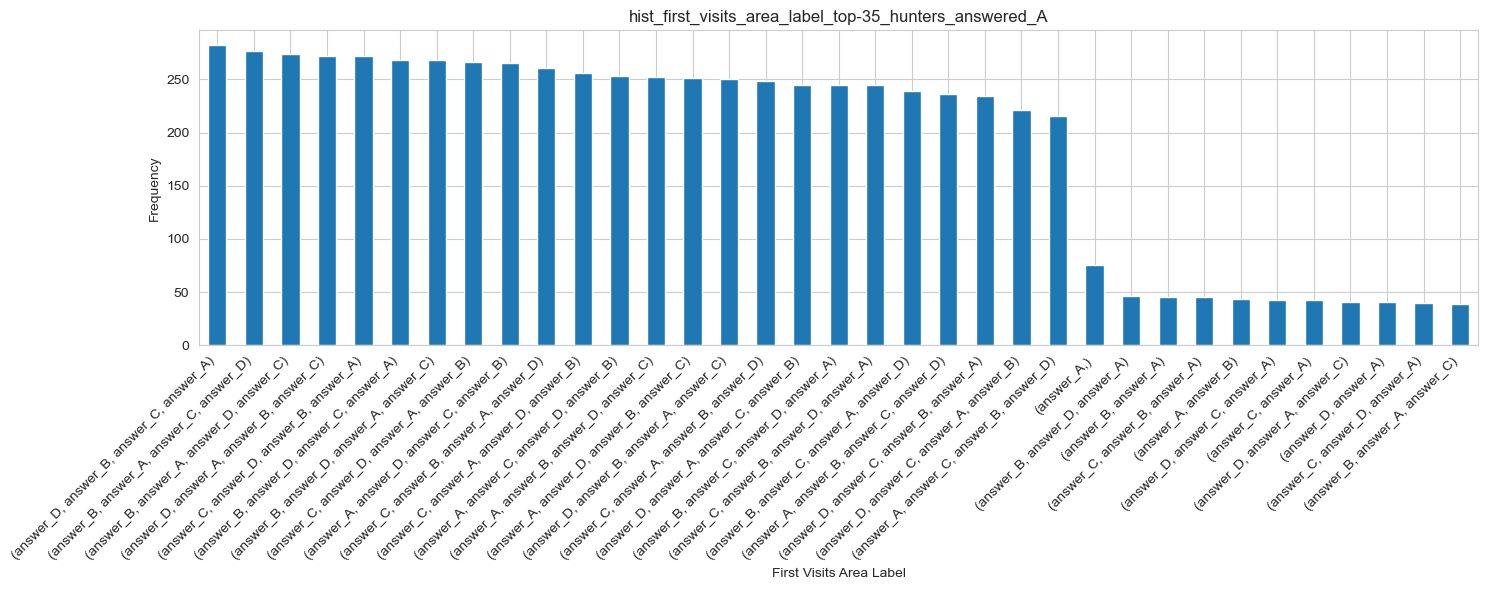

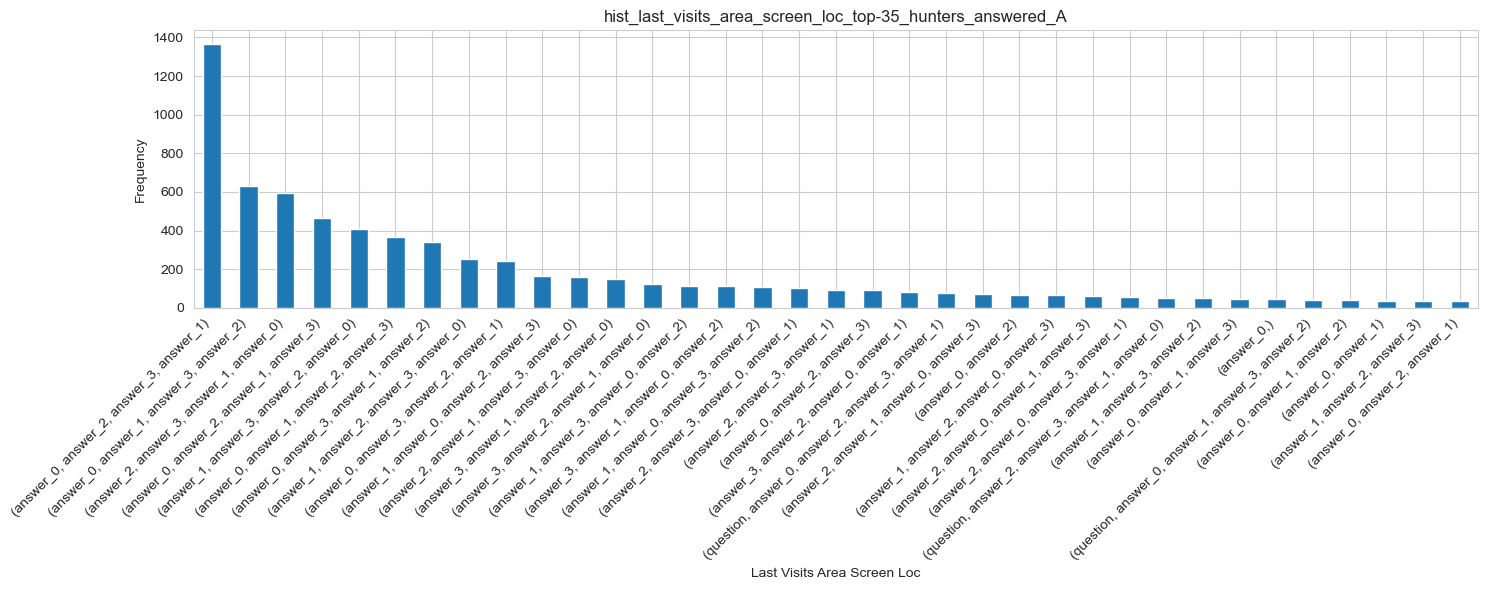

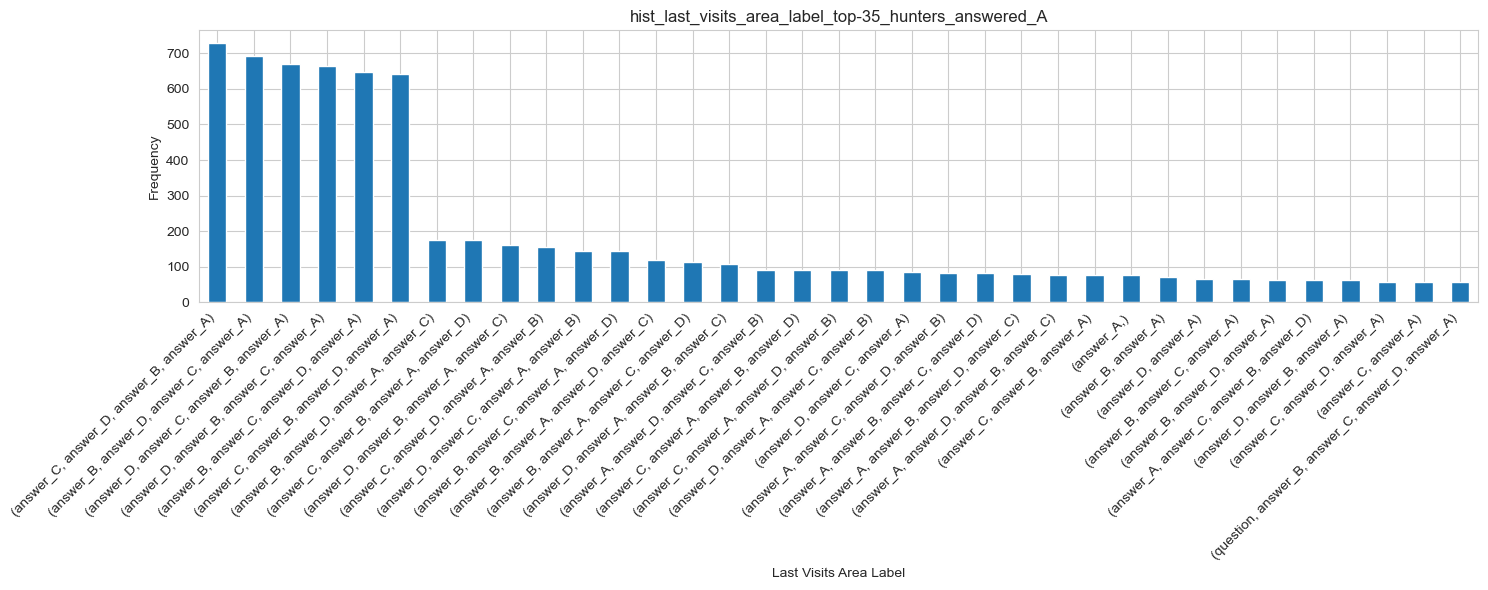

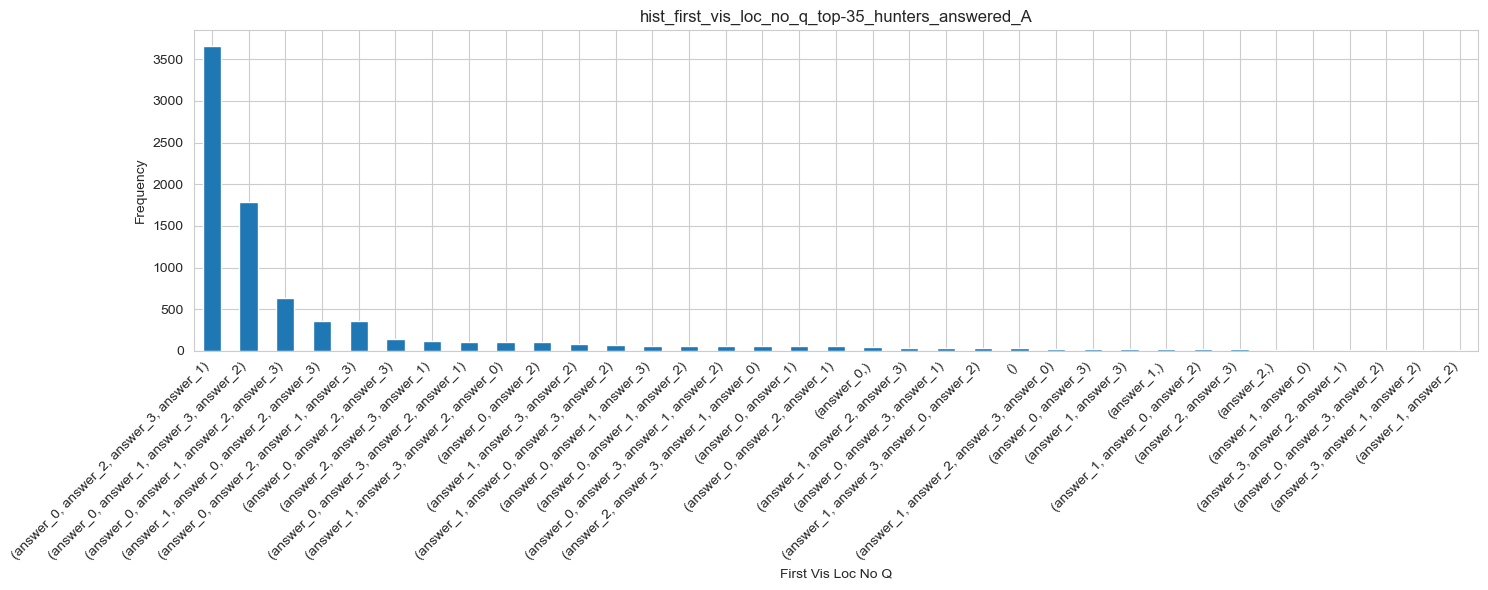

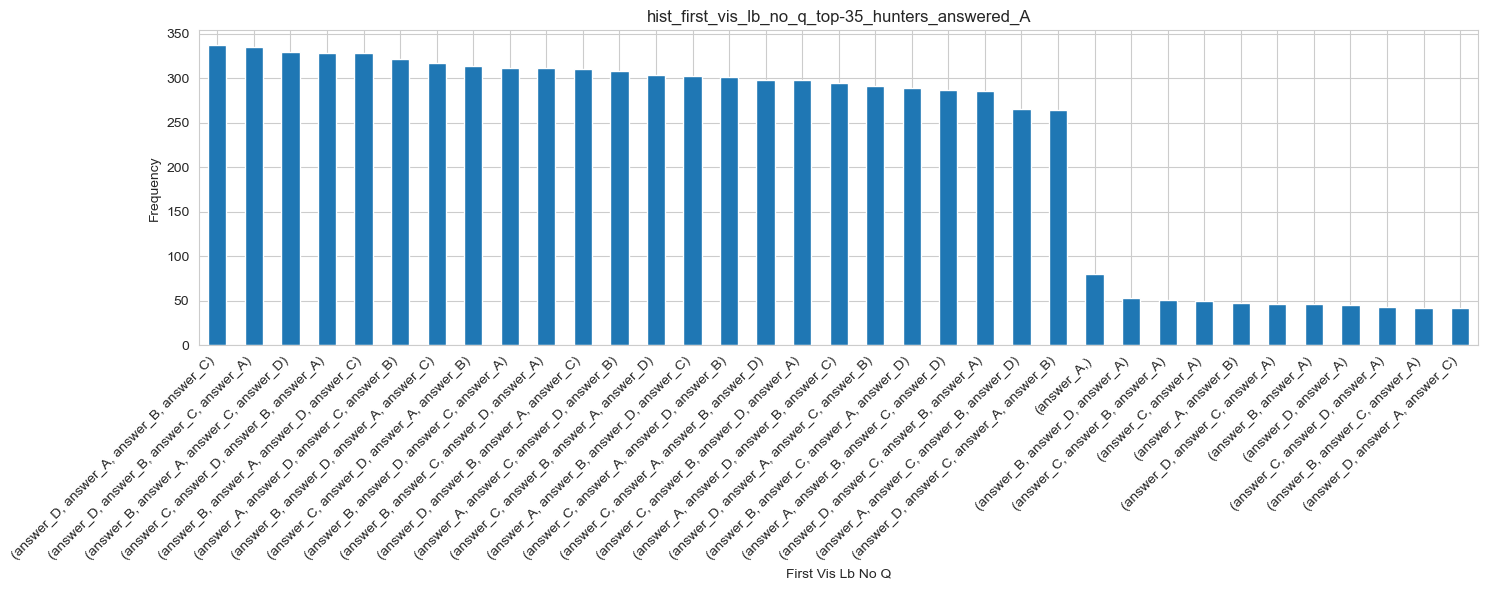

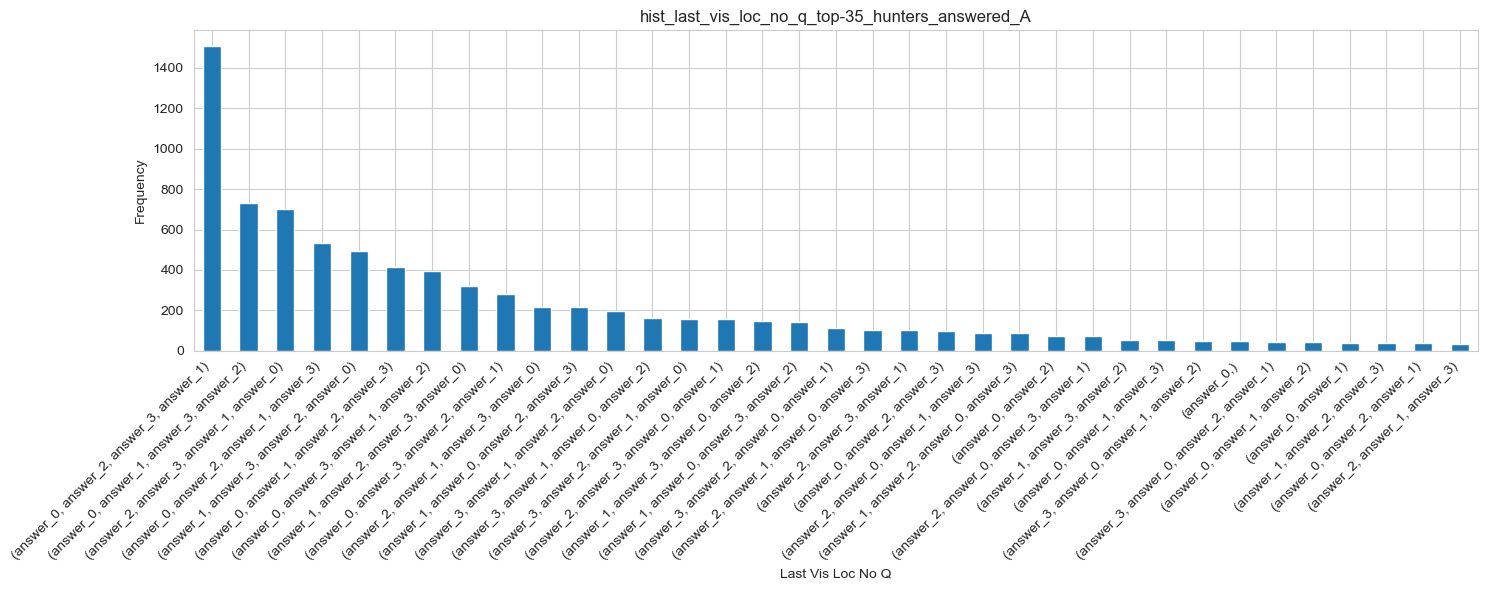

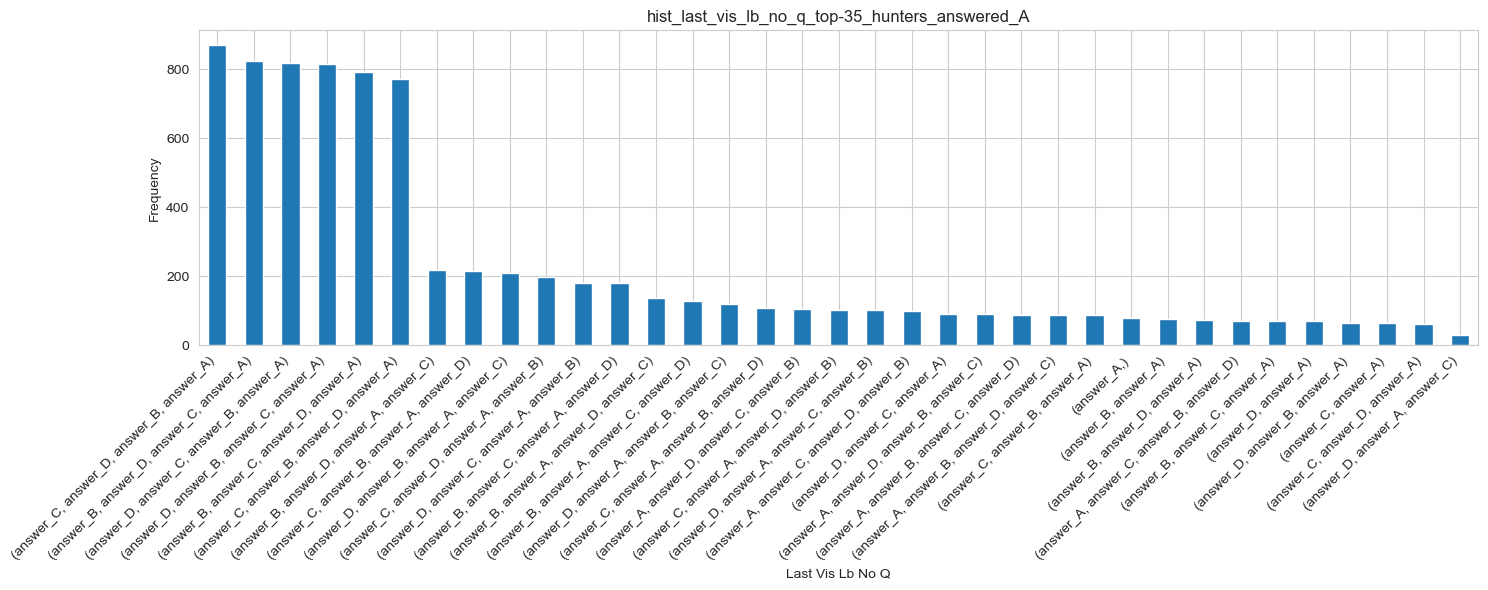

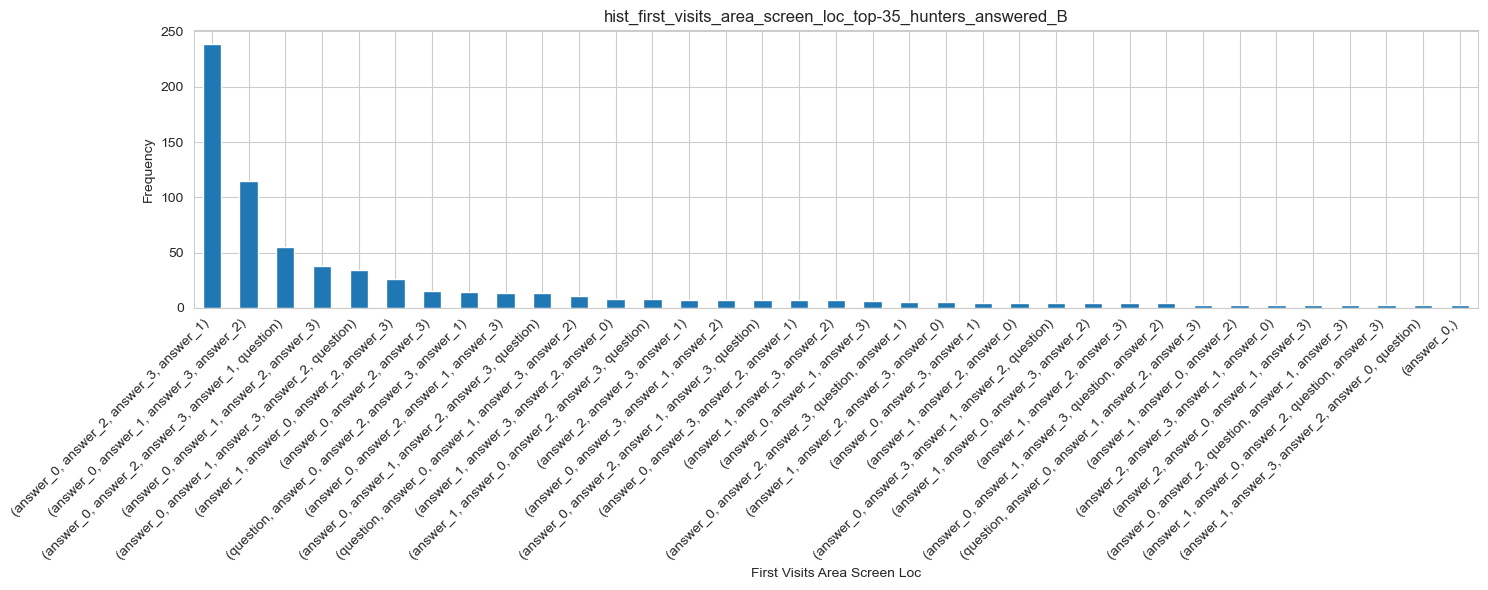

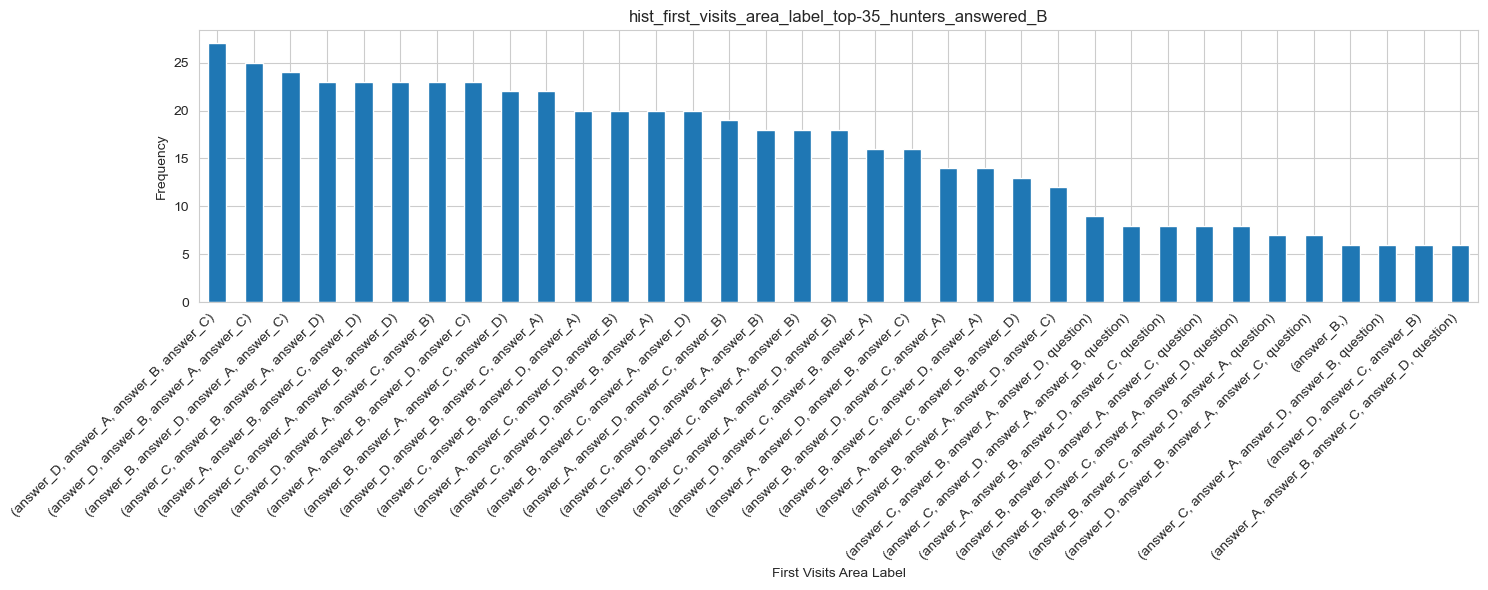

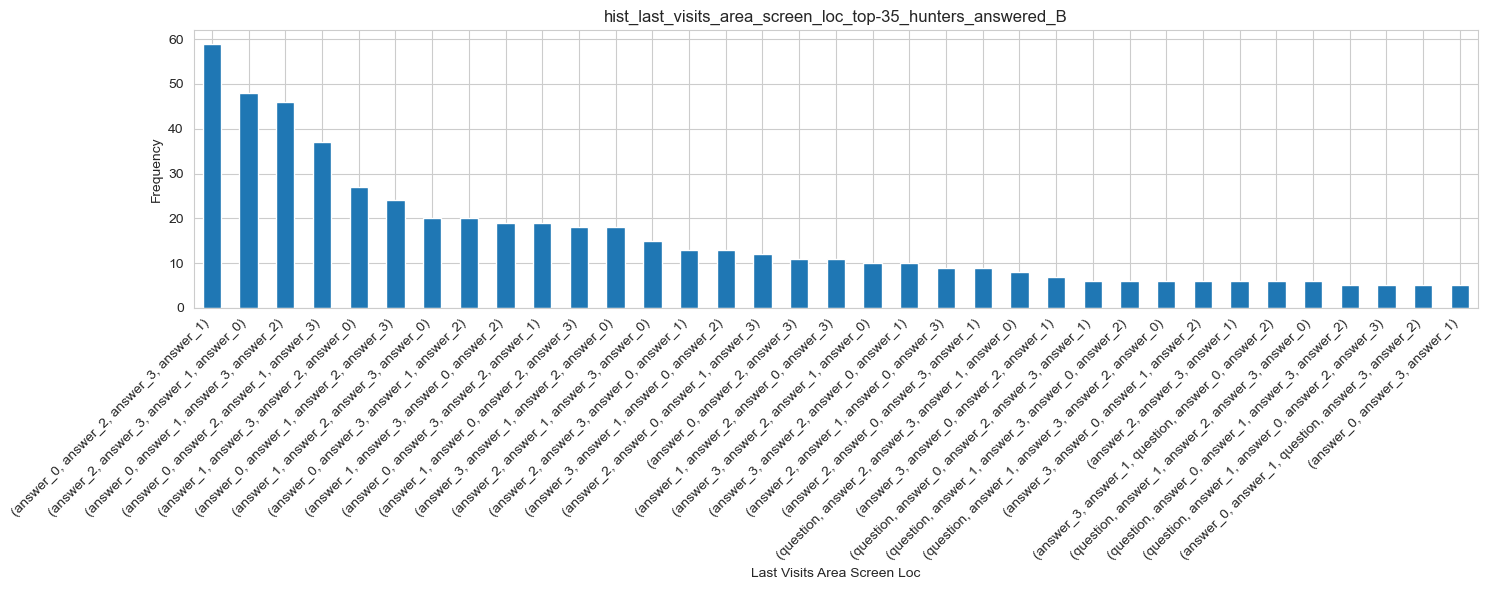

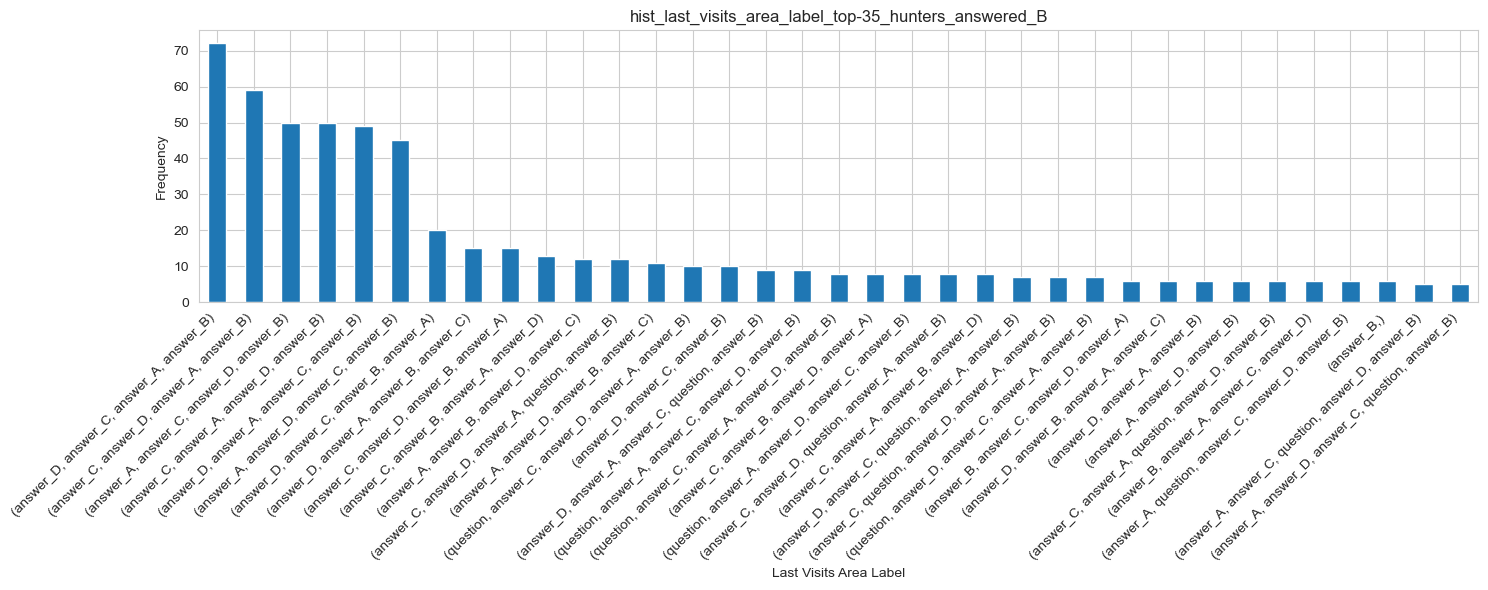

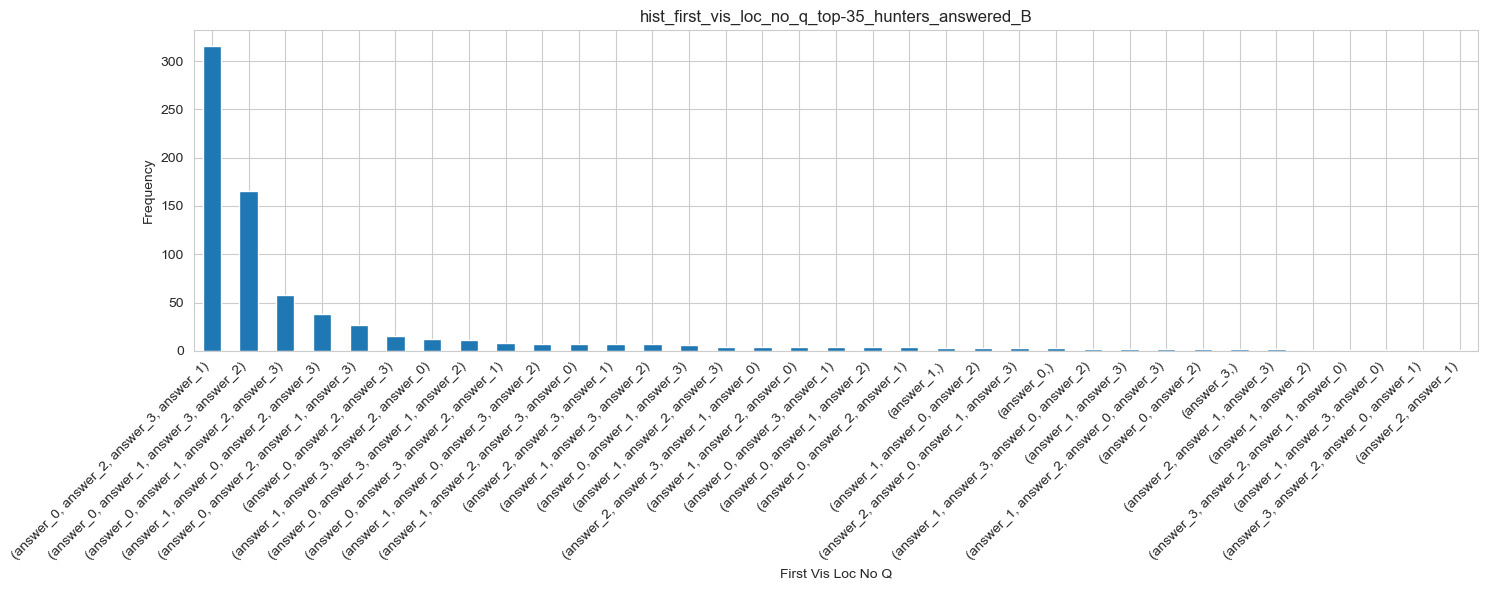

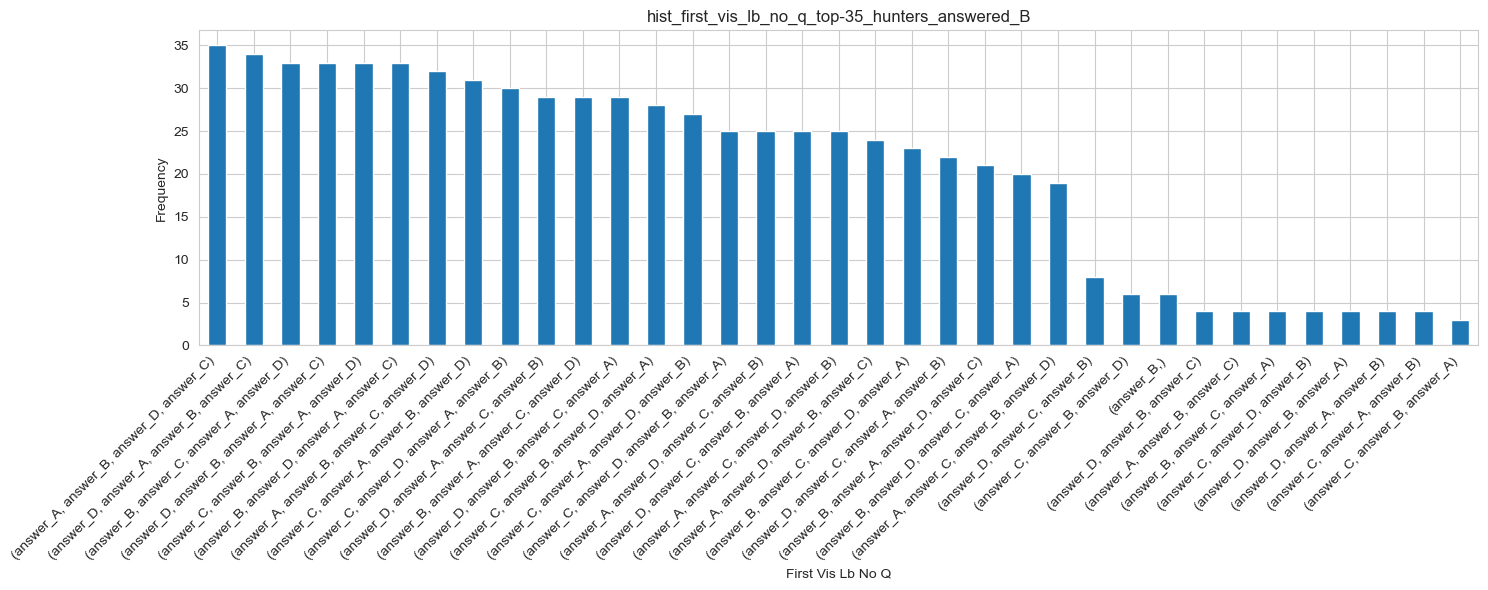

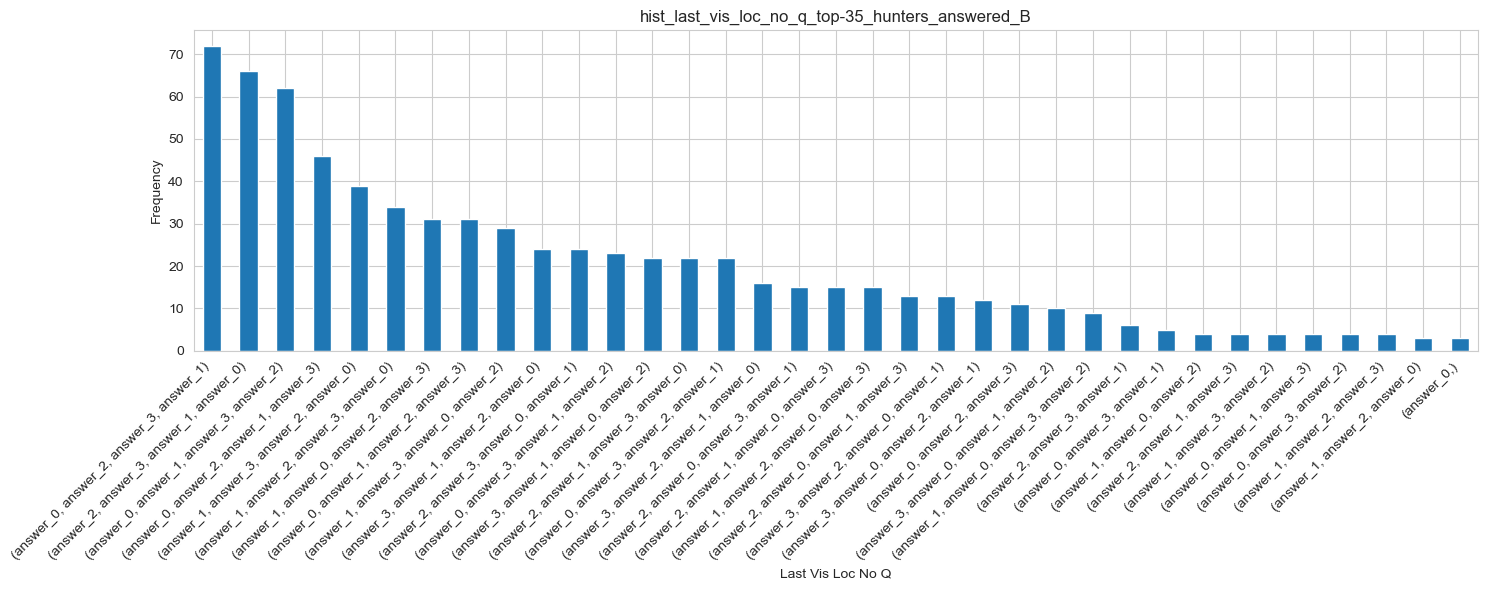

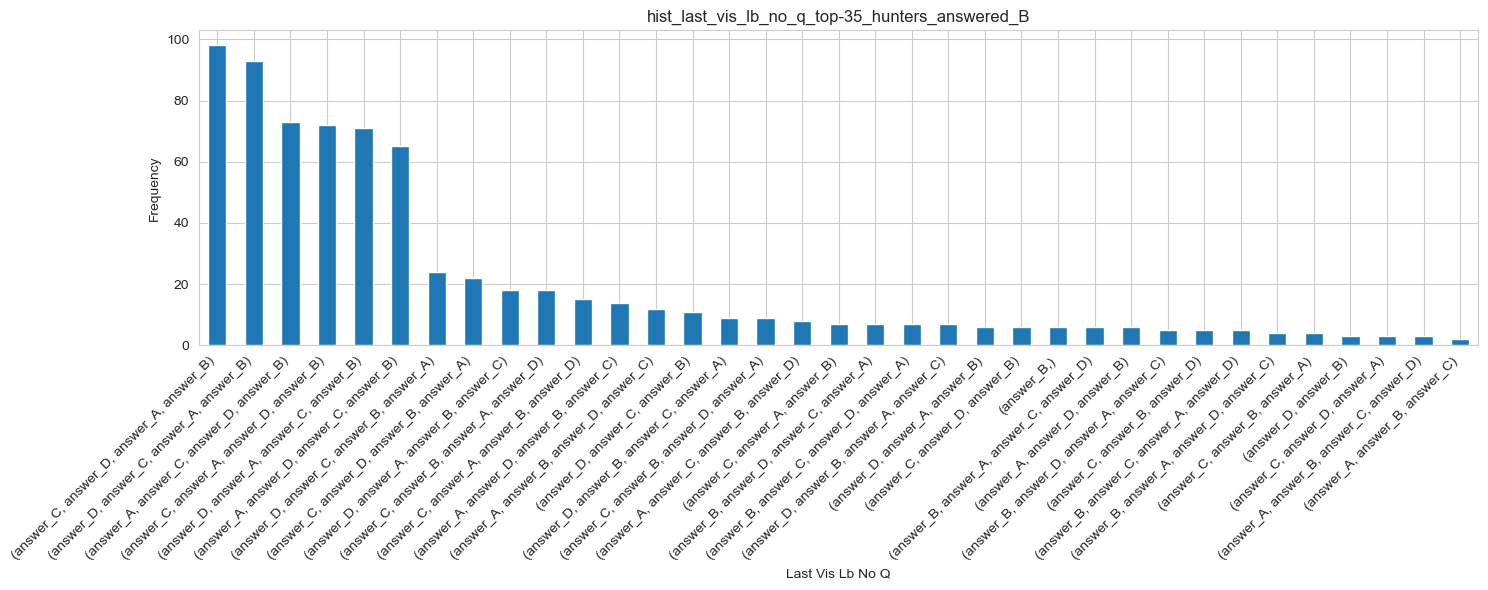

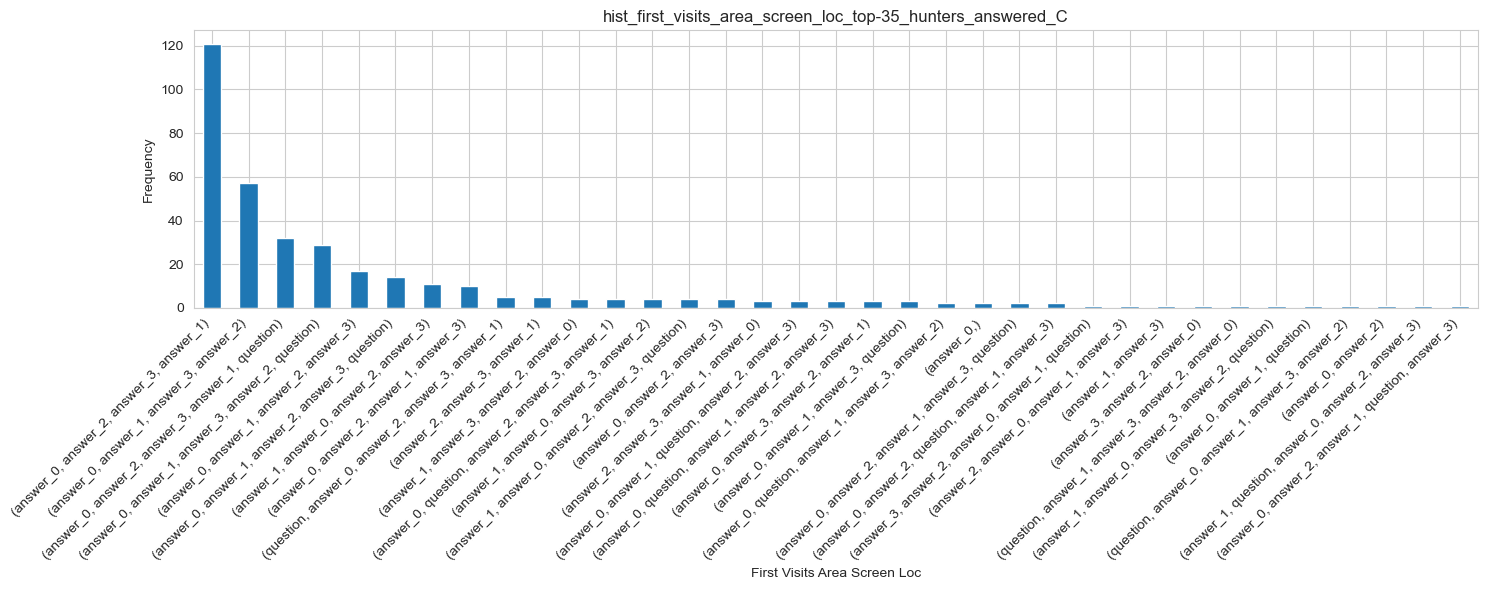

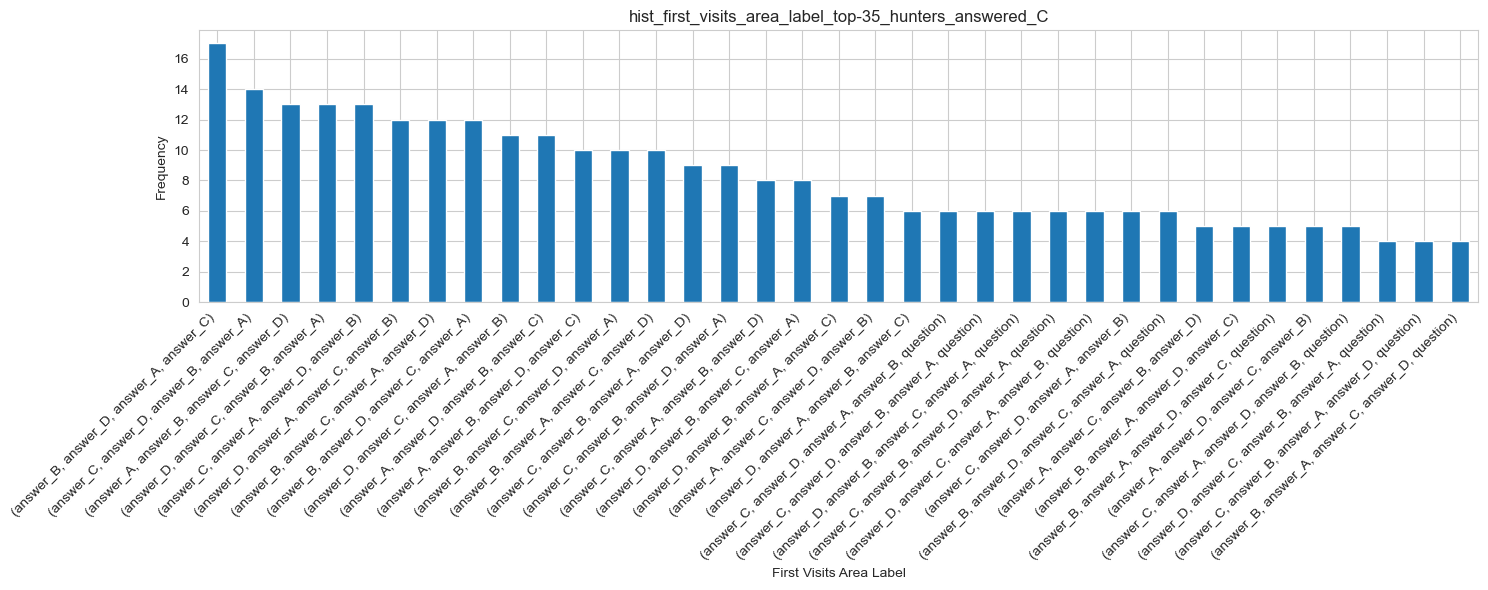

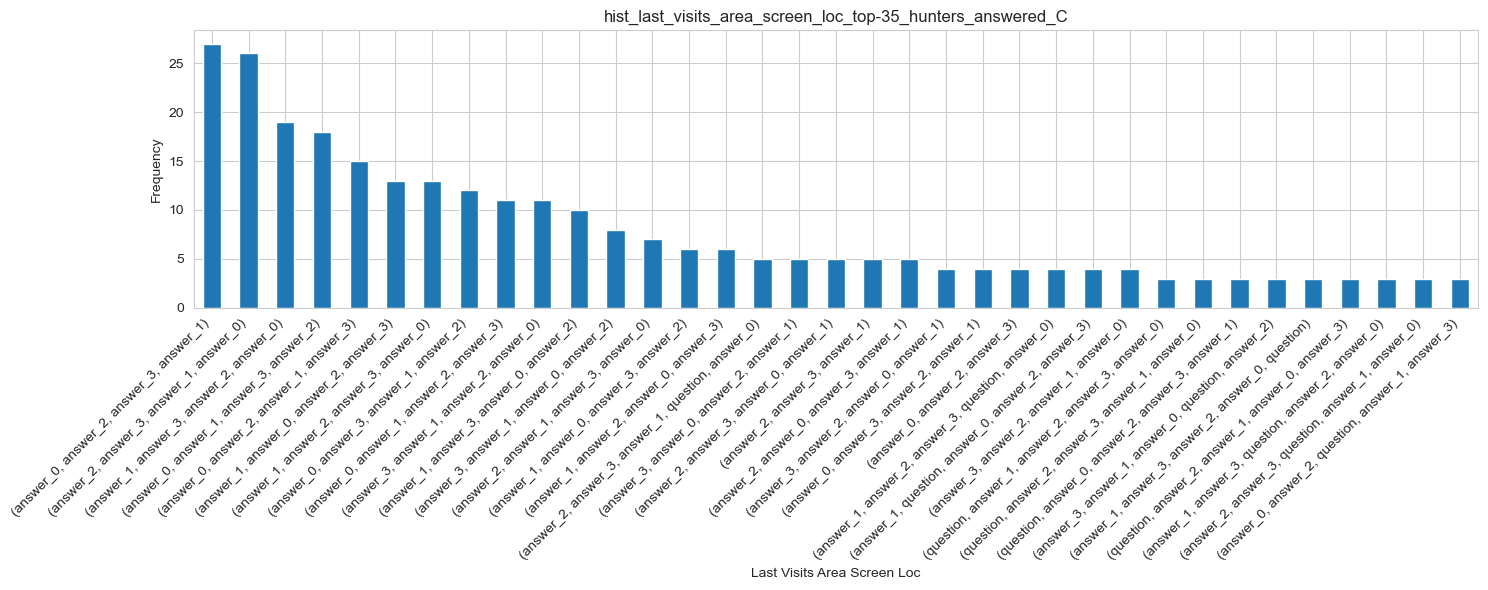

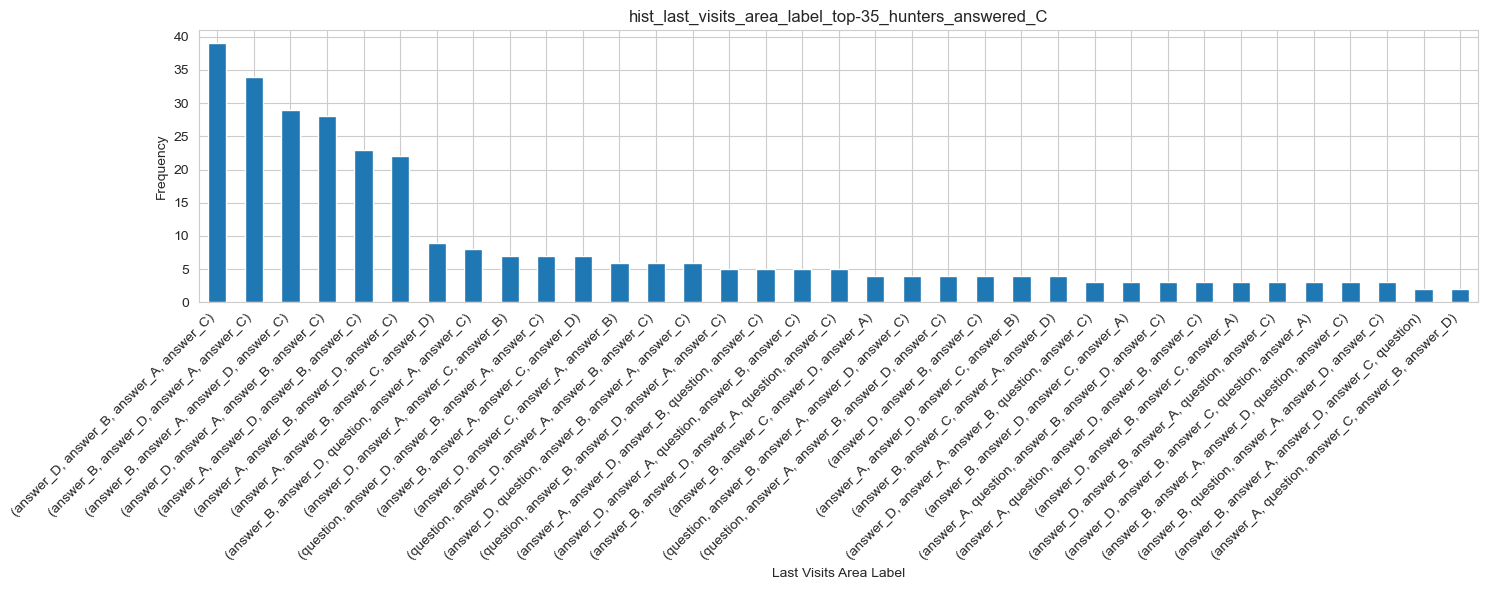

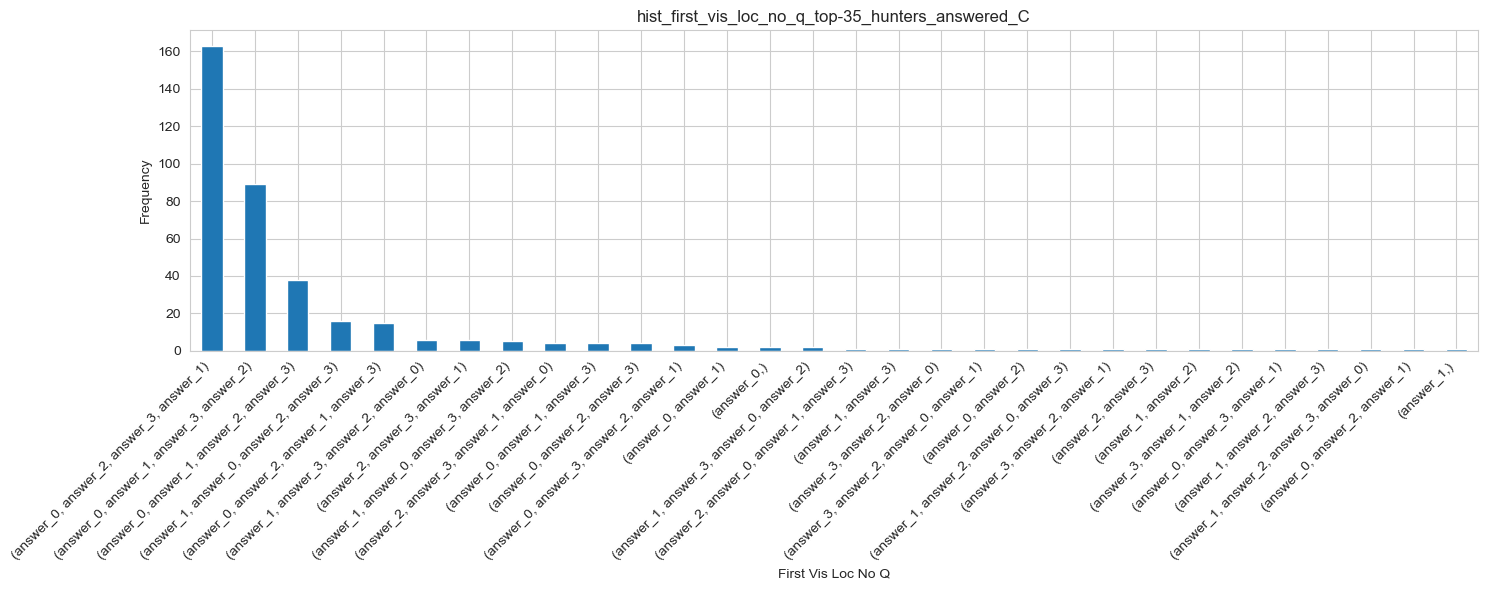

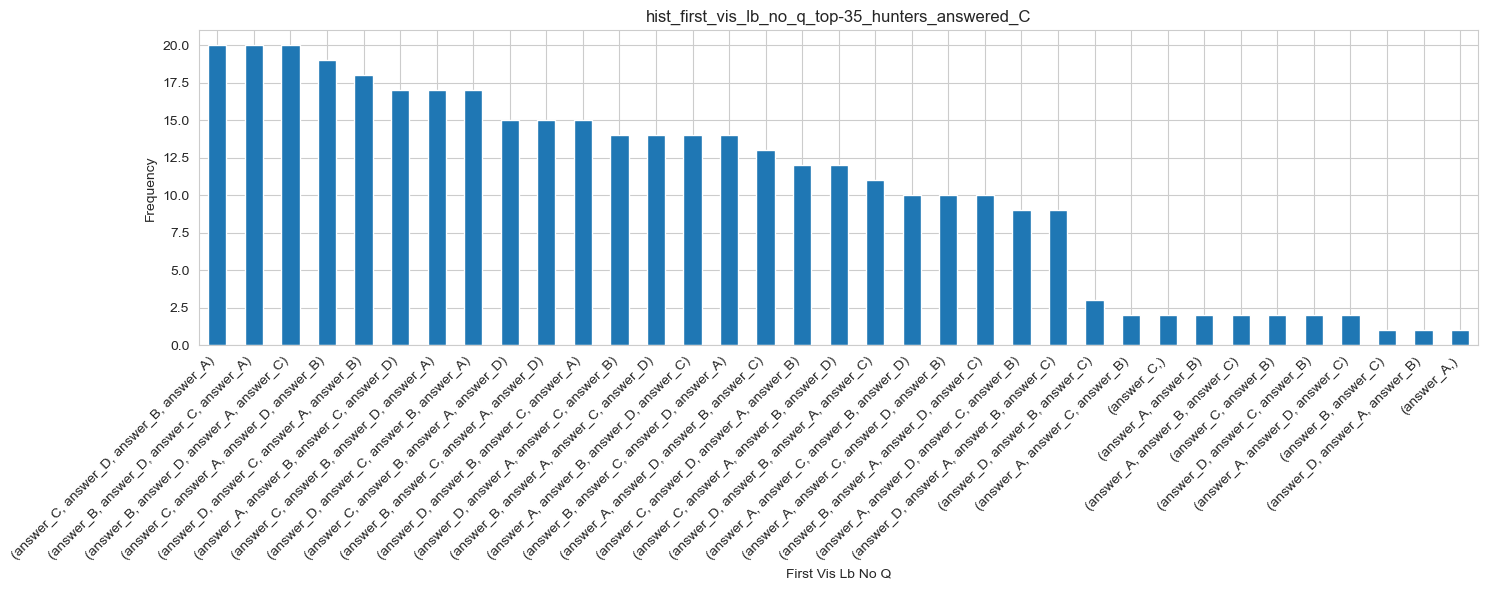

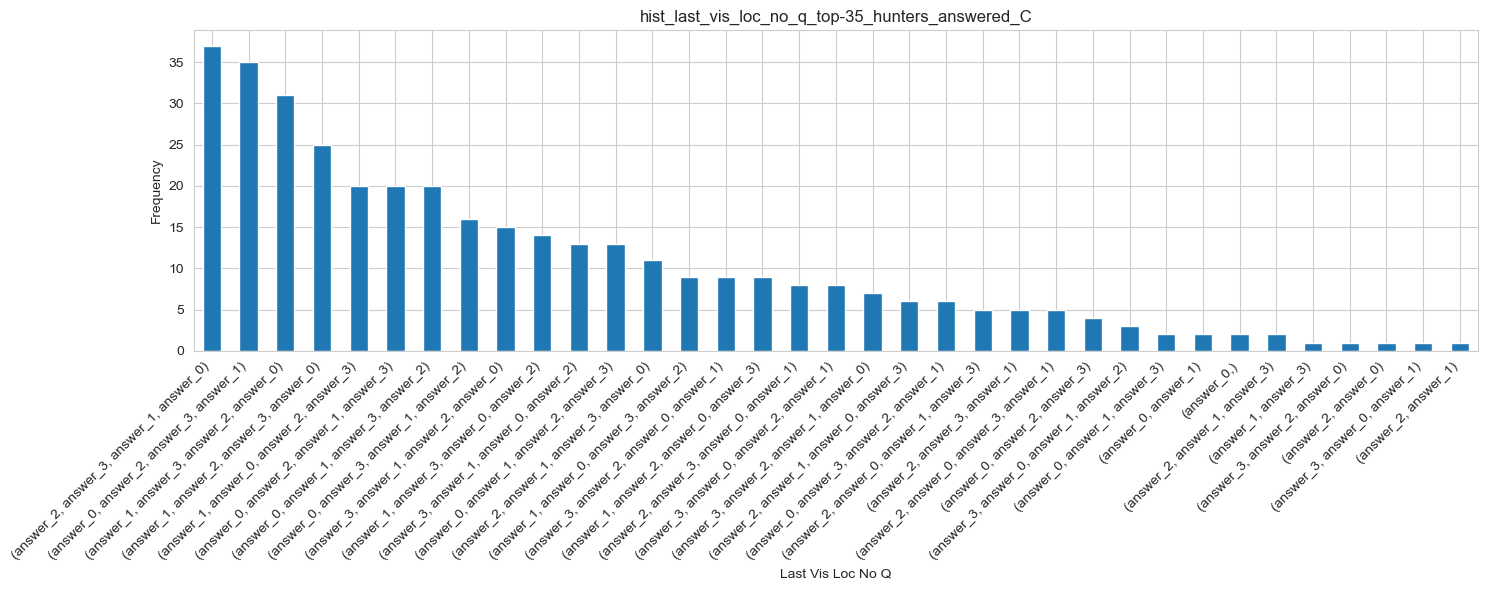

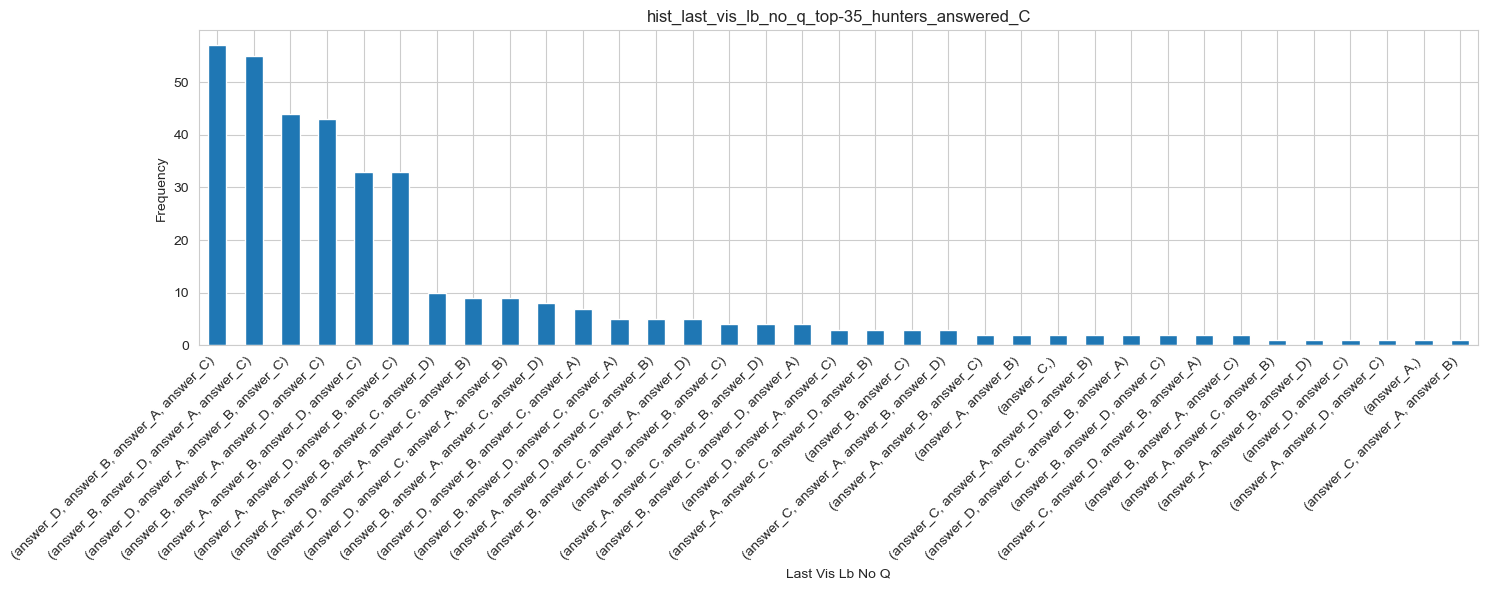

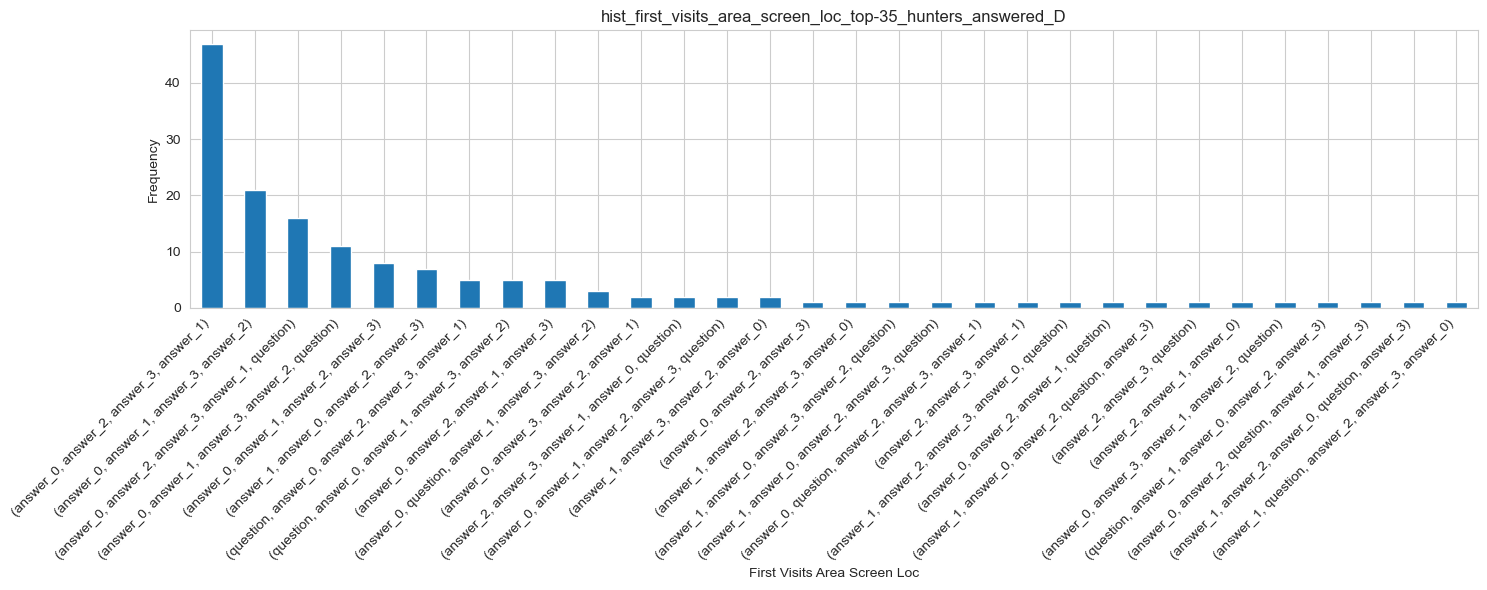

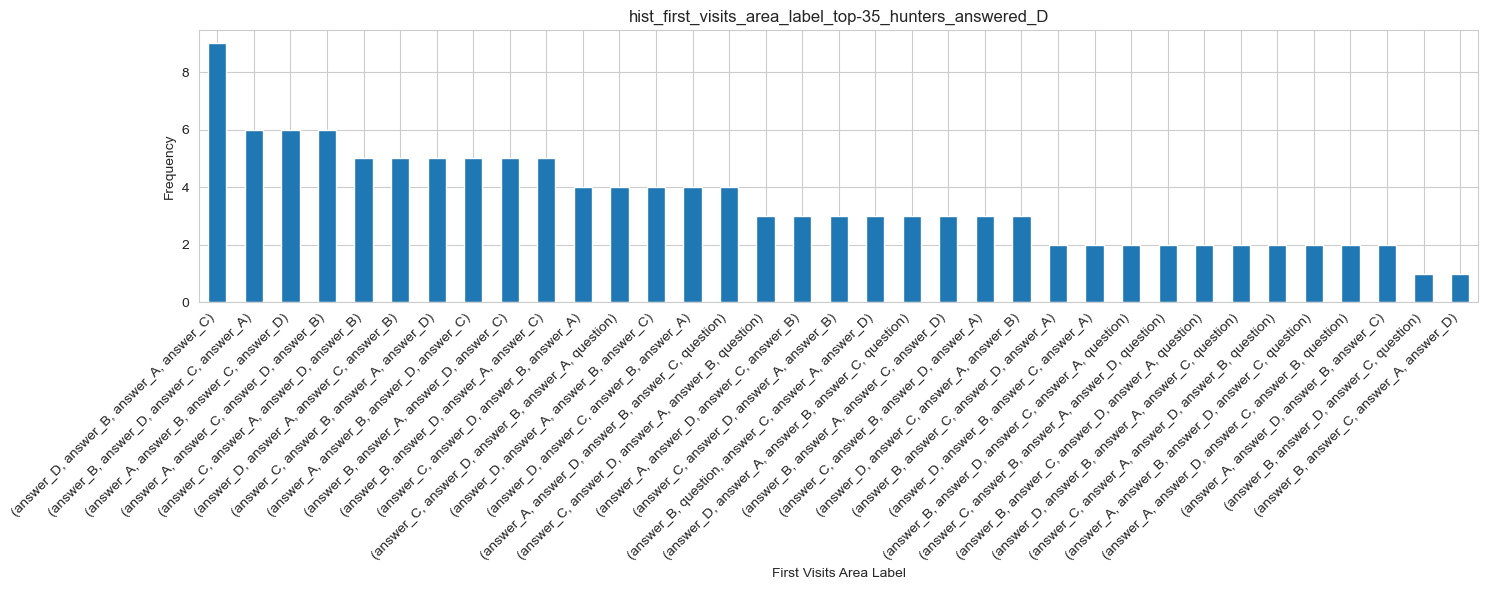

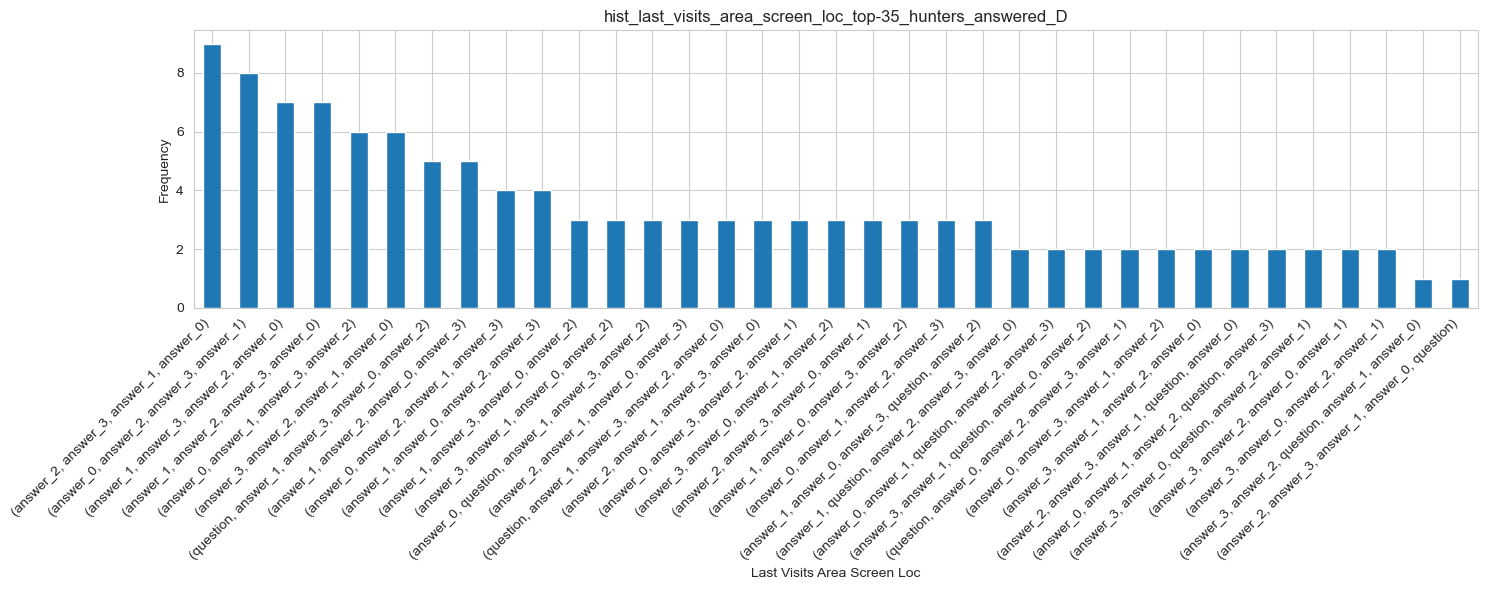

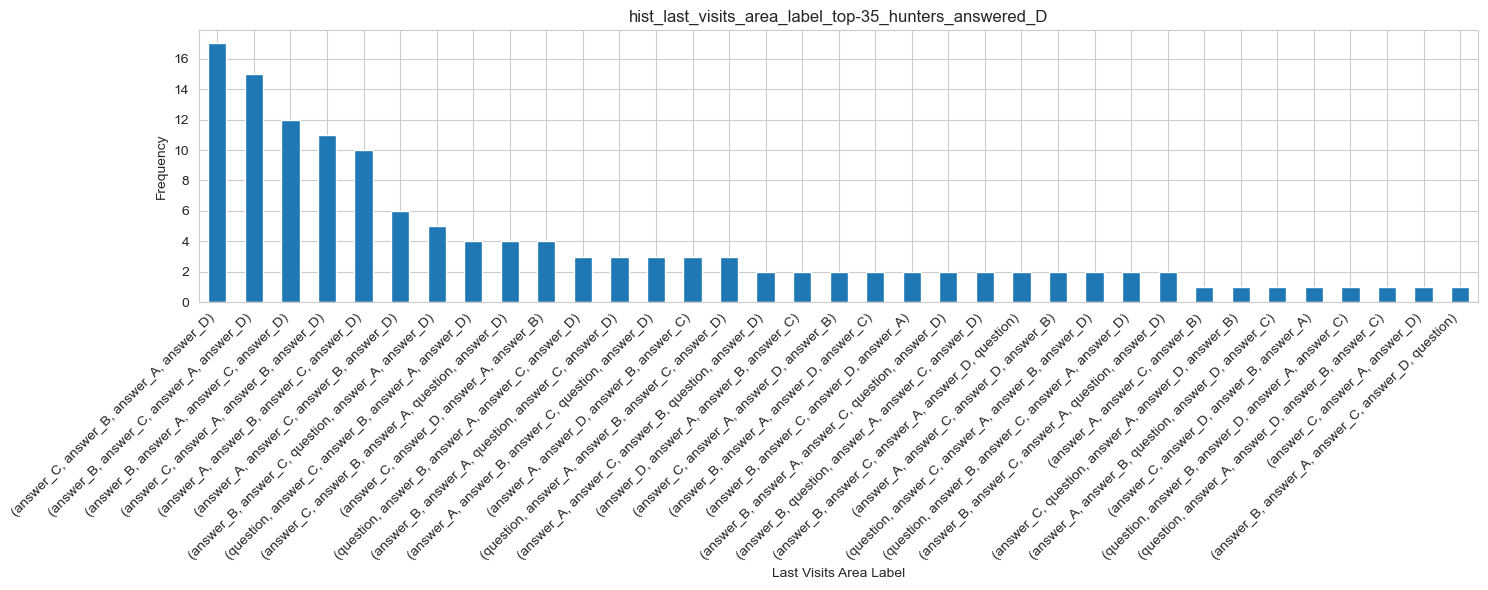

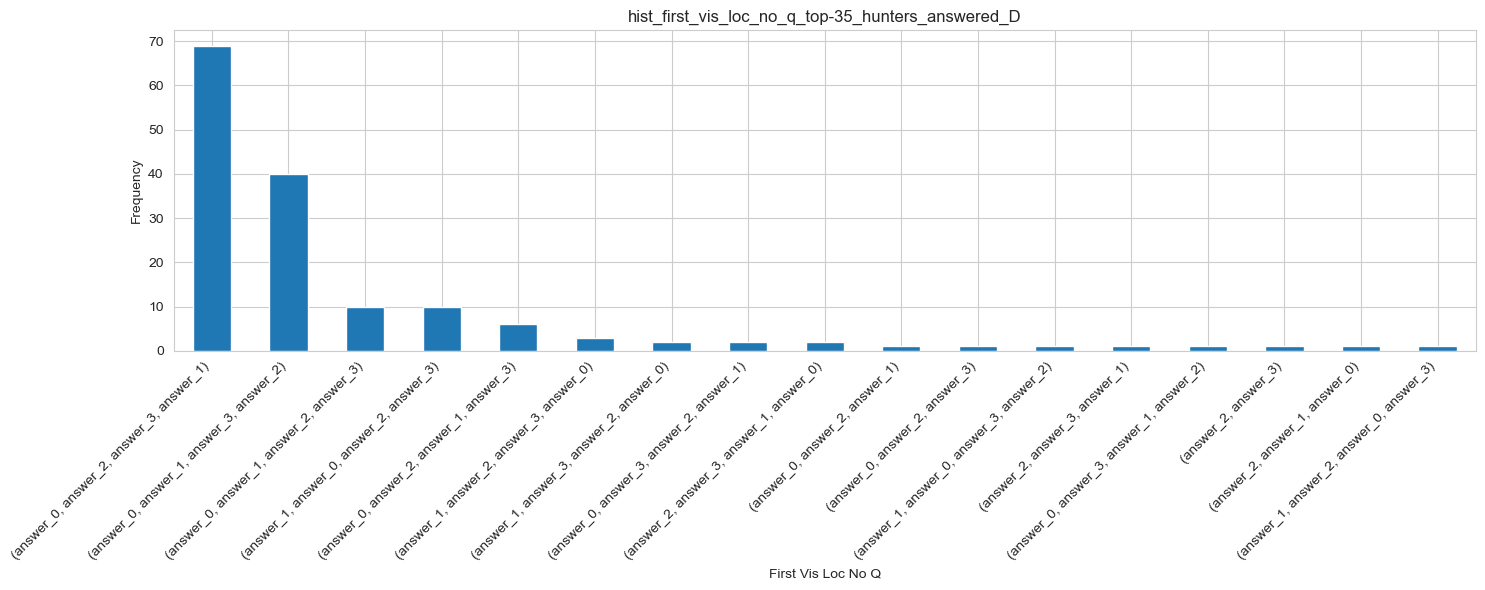

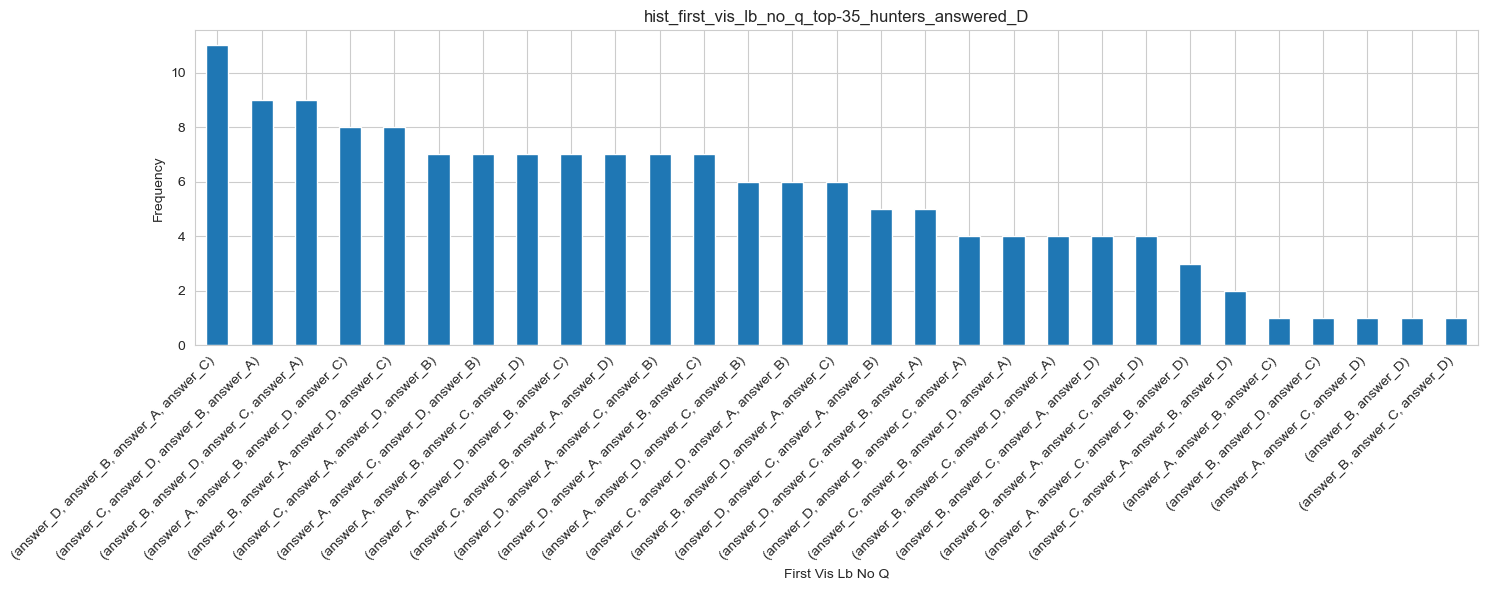

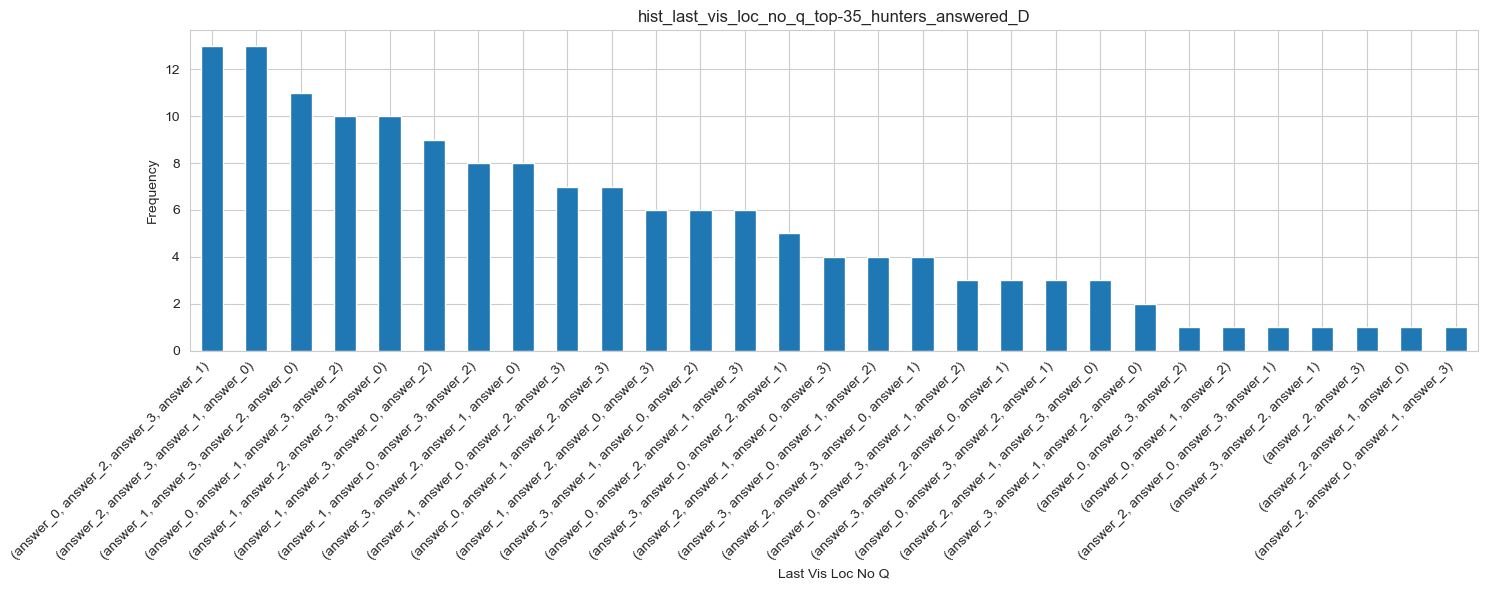

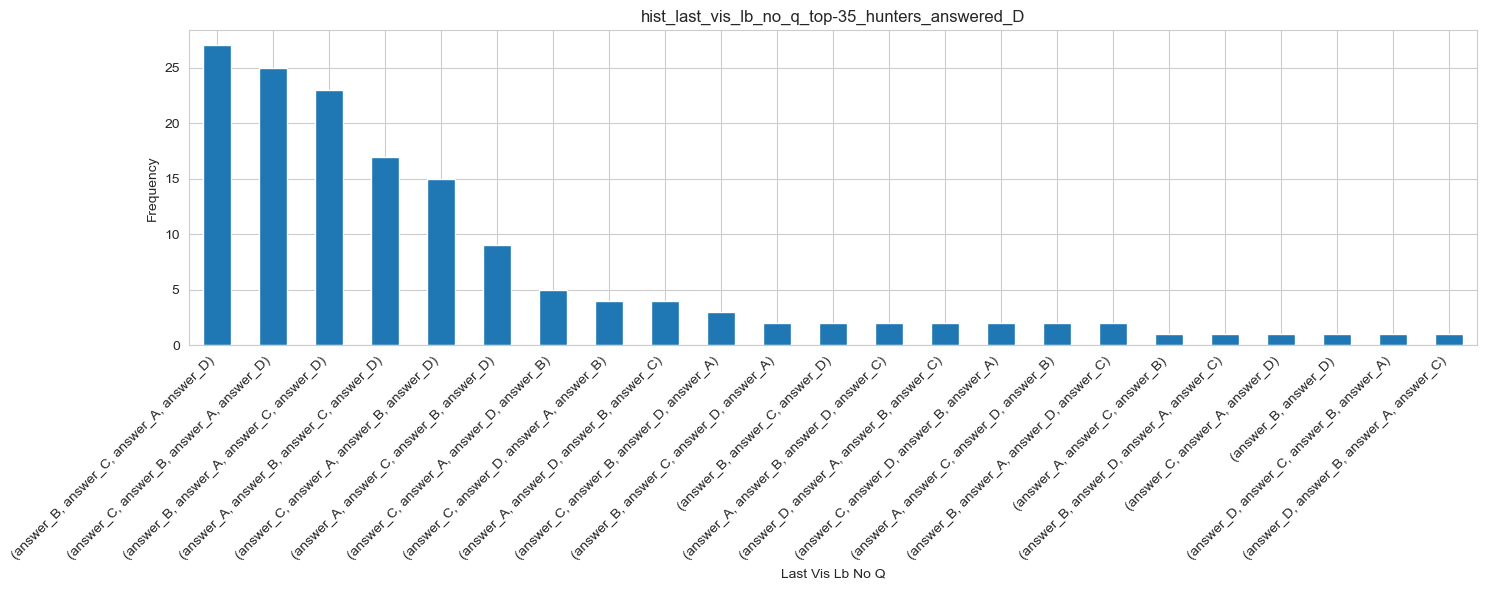

In [50]:
for l in ['A', 'B', 'C', 'D']:
    data = df_with_features_h[df_with_features_h['selected_answer_label'] == l]
    for col in ['first_visits_area_screen_loc', 'first_visits_area_label', 'last_visits_area_screen_loc', 'last_visits_area_label',
                'first_vis_loc_no_q', 'first_vis_lb_no_q', 'last_vis_loc_no_q', 'last_vis_lb_no_q']:
        df = data[['TRIAL_INDEX', 'participant_id', col]].drop_duplicates()
        plot_freq_hist(df, column=col, top_n=35, h_or_g = 'hunters', ans = l)

### Distance measure

In [27]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan
import matplotlib.pyplot as plt
import umap

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import leaves_list
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

from Bio import pairwise2

#### 1. Self made

In [28]:
def sequence_distance(item1, item2, dist=1):
    m = 0.83

    fix_seq1, fix_dur1, _, _ = item1
    fix_seq2, fix_dur2, _, _ = item2

    fix_seq1, fix_dur1 = list(fix_seq1), list(fix_dur1)
    fix_seq2, fix_dur2 = list(fix_seq2), list(fix_dur2)

    if not fix_seq1:
        fix_seq1 = [0]
        fix_dur1 = [0]
    if not fix_seq2:
        fix_seq2 = [0]
        fix_dur2 = [0]

    alignments = pairwise2.align.globalxx(fix_seq1, fix_seq2,gap_char=['-'])
    best_alignment = alignments[0]
    aln_tokens1 = best_alignment[0]
    aln_tokens2 = best_alignment[1]

    aligned_dur1 = []
    aligned_dur2 = []
    idx1 = 0
    idx2 = 0

    for token_a, token_b in zip(aln_tokens1, aln_tokens2):
        if token_a == "-":
            aligned_dur1.append(0)
        else:
            aligned_dur1.append(fix_dur1[idx1])
            idx1 += 1

        if token_b == "-":
            aligned_dur2.append(0)
        else:
            aligned_dur2.append(fix_dur2[idx2])
            idx2 += 1

    total_distance = 0
    for s1, d1, s2, d2 in zip(aln_tokens1, aligned_dur1, aln_tokens2, aligned_dur2):
        if s1 == s2:
            total_distance += abs(d1 - d2) * (m**dist)
        else:
            total_distance += (d1 + d2) * (m**dist)

    return total_distance

#### 2. Levenshtein

In [29]:
import Levenshtein
def levenshtein_sequence_distance(item1, item2):
    return Levenshtein.distance(item1[0], item2[0])

#### 3. R wrapper

In [30]:
%load_ext rpy2.ipython

C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [31]:
%%R
# rpy2.library("devtools")
# rpy2.install_github("tmalsburg/scanpath/scanpath", dependencies=TRUE)
# rpy2.library(scanpath)

library(devtools)
install_github("tmalsburg/scanpath/scanpath", dependencies=TRUE)
library(scanpath)

R[write to console]: Loading required package: usethis

R[write to console]: Using GitHub PAT from the git credential store.

R[write to console]: Skipping install of 'scanpath' from a github remote, the SHA1 (6984b604) has not changed since last install.
  Use `force = TRUE` to force installation



In [32]:
import numpy as np
import pandas as pd
import rpy2.robjects as ro


def scasim_py(
    df: pd.DataFrame,
    formula: str,
    center_x: int = 1280,
    center_y: int = 720,
    viewing_distance: int = 77,
    unit_size: float = 1 / 60,
    normalize: bool | str = False,
) -> np.ndarray:
    ro.pandas2ri.activate()
    scanpath = ro.packages.importr(name="scanpath")

    with (ro.default_converter + ro.pandas2ri.converter).context():
        r_dataframe = ro.conversion.get_conversion().py2rpy(df)

    return scanpath.scasim(
        data=r_dataframe,
        formula=ro.Formula(formula),
        center_x=center_x,
        center_y=center_y,
        viewing_distance=viewing_distance,
        unit_size=unit_size,
        normalize=normalize,
    )


def alignment_plot_py(
    sp1: pd.DataFrame,
    sp2: pd.DataFrame,
    diff_by: str = "synthesized",
    center_x: int = 1280,
    center_y: int = 720,
    viewing_distance: int = 77,
    unit_size: float = 1 / 60,
):
    ro.pandas2ri.activate()
    scanpath = ro.packages.importr(name="scanpath")
    ggplot = ro.packages.importr("ggplot2")

    with (ro.default_converter + ro.pandas2ri.converter).context():
        sp_r_df_1 = ro.conversion.get_conversion().py2rpy(sp1)
        sp_r_df_2 = ro.conversion.get_conversion().py2rpy(sp2)

    alignment = scanpath.rscasim(
        sp_r_df_1,
        sp_r_df_2,
        formula=ro.Formula(
            f"CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | {diff_by}"
        ),
        center_x=center_x,
        center_y=center_y,
        viewing_distance=viewing_distance,
        unit_size=unit_size,
    )

    alignment_plot = scanpath.plot_alignment(
        sp_r_df_1,
        sp_r_df_2,
        ro.conversion.get_conversion().py2rpy(alignment),
        ro.Formula(f"CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | {diff_by}"),
        10,
        10,
    )

    # save the plot
    ggplot.ggsave(
        ro.conversion.get_conversion().py2rpy(alignment_plot), "alignment_plot.png"
    )

In [33]:
def scasim_sequence_distance(item1, item2):
    """
    Wrap R’s scanpath::scasim via scasim_py so that it looks like
    any other `distance_func(item1, item2)` in our pipeline.
    """
    seq1, dur1, x1, y1 = item1
    seq2, dur2, x2, y2 = item2

    if not dur1:
        dur1, x1, y1 = [0], [0], [0]
    if not dur2:
        dur2, x2, y2 = [0], [0], [0]

    df1 = pd.DataFrame({
        "CURRENT_FIX_DURATION": dur1,
        "CURRENT_FIX_X":         x1,
        "CURRENT_FIX_Y":         y1,
        "trial":                 1
    })
    df2 = pd.DataFrame({
        "CURRENT_FIX_DURATION": dur2,
        "CURRENT_FIX_X":         x2,
        "CURRENT_FIX_Y":         y2,
        "trial":                 2
    })
    df_combined = pd.concat([df1, df2], ignore_index=True)

    dist_mat = scasim_py(
        df=df_combined,
        formula="CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | trial"
    )
    dist_mat = np.asarray(dist_mat)

    return float(dist_mat[0, 1])


In [75]:
# def scasim_sequence_distance(df, col, formula):
#     exploded = (df
#         .loc[:, [col, 'simpl_fix_duration', 'simpl_fix_x', 'simpl_fix_y']]
#         .explode(['simpl_fix_duration','simpl_fix_x','simpl_fix_y'])
#         .rename(columns={
#           'simpl_fix_duration':'CURRENT_FIX_DURATION',
#           'simpl_fix_x':'CURRENT_FIX_X',
#           'simpl_fix_y':'CURRENT_FIX_Y',
#         })
#     )
#     exploded['trial'] = exploded[col]
#     exploded[['CURRENT_FIX_DURATION','CURRENT_FIX_X','CURRENT_FIX_Y']] =\
#         (
#         exploded[[
#           'CURRENT_FIX_DURATION','CURRENT_FIX_X','CURRENT_FIX_Y'
#         ]].astype(float))
#
#     exploded = exploded.dropna(subset=[
#         'CURRENT_FIX_DURATION',
#         'CURRENT_FIX_X',
#         'CURRENT_FIX_Y'
#     ])
#
#     return scasim_py(
#       df=exploded,
#       formula="CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | trial",
#     )

### Clusterers

In [50]:
def seq_cluster_kmeans(df, seq_col, dur_col, x_col, y_col, distance_func=sequence_distance,
                       n_clusters=5, mds_components=30, dist_mat = None):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col]), axis=1).tolist()

    if not dist_mat:
        n = len(items)
        distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = distance_func(items[i], items[j])
                distance_matrix[i, j] = d
                distance_matrix[j, i] = d
    else:
        distance_matrix = dist_mat

    mds = MDS(n_components=mds_components, dissimilarity='precomputed')
    mds_embedding = mds.fit_transform(distance_matrix)

    kmeans_clusterer = KMeans(n_clusters=n_clusters)
    labels = kmeans_clusterer.fit_predict(mds_embedding)

    return distance_matrix, labels

In [51]:
def seq_cluster_agglomerative(df, seq_col, dur_col, x_col, y_col, distance_func=sequence_distance, n_clusters=5):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    clusterer = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, metric='precomputed')
    labels = clusterer.fit_predict(distance_matrix)
    return distance_matrix, labels


In [52]:
def seq_cluster_dbscan(df, seq_col, dur_col, x_col, y_col, distance_func=sequence_distance, eps=0.99, min_samples=2):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = clusterer.fit_predict(distance_matrix)

    return distance_matrix, labels

In [53]:
def seq_cluster_hdbscan(df, seq_col, dur_col, x_col, y_col, distance_func=sequence_distance, min_cluster_size=2):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(distance_matrix)

    return distance_matrix, labels

### Mixing the Sequences

In [54]:
def mix_fix(df,
                  loc_col='simpl_fix_by_loc',
                  label_col='simpl_fix_by_label',
                  result_col='simpl_fix_mixed',
                  n_loc=4):
    df = df.copy()
    df[result_col] = df.apply(
        lambda r: tuple(r[loc_col])[:n_loc] + tuple(r[label_col])[n_loc:],
        axis=1
    )
    return df

df_with_features_h = mix_fix(df_with_features_h,
                                   loc_col='simpl_fix_by_loc',
                                   label_col='simpl_fix_by_label',
                                   result_col='simpl_fix_mixed',
                                   n_loc=4)
df_with_features_g = mix_fix(df_with_features_g,
                                   loc_col='simpl_fix_by_loc',
                                   label_col='simpl_fix_by_label',
                                   result_col='simpl_fix_mixed',
                                   n_loc=4)


df_with_features_h = mix_fix(df_with_features_h,
                                   loc_col='fix_by_loc',
                                   label_col='fix_by_label',
                                   result_col='fix_mixed',
                                   n_loc=4)
df_with_features_g = mix_fix(df_with_features_g,
                                   loc_col='fix_by_loc',
                                   label_col='fix_by_label',
                                   result_col='fix_mixed',
                                   n_loc=4)

### Clustering Visualization

In [68]:
def plot_custom_dendrogram(distance_matrix, subset, tid, seq_col):
    linkage_matrix = linkage(distance_matrix, method='average')
    custom_labels = [", ".join(map(str, seq)) for seq in subset[seq_col]]

    plt.figure(figsize=(12, 6))
    plt.title(f"Dendrogram for text_id: {tid}")
    dendrogram(linkage_matrix, labels=custom_labels,
               leaf_rotation=90,
               leaf_font_size=10)
    plt.xlabel(f"Fixation Sequences ({seq_col}])")
    plt.ylabel("Distance")
    plt.show()

In [69]:
def pca_plot(distance_matrix, labels, tid, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(distance_matrix)

    plt.figure(figsize=(8,6))
    plt.title(f"PCA Projection for text_id: {tid}")
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='plasma')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

In [70]:
def reordered_heatmap(condensed_distance, distance_matrix, tid):
    linkage_matrix = linkage(condensed_distance, method='average')
    leaf_order = leaves_list(linkage_matrix)
    reordered_matrix = distance_matrix[leaf_order][:, leaf_order]

    plt.figure(figsize=(8, 6))
    plt.title(f"Reordered Distance Matrix for text_id: {tid}")
    im = plt.imshow(reordered_matrix, cmap='viridis', interpolation='nearest')
    plt.xlabel("Reordered Index")
    plt.ylabel("Reordered Index")
    plt.colorbar(im)
    plt.show()

In [71]:
def umap_plot(distance_matrix, labels, tid):
    umap_model = umap.UMAP(metric='precomputed', random_state=42)
    umap_emb = umap_model.fit_transform(distance_matrix)
    plt.figure(figsize=(8, 6))
    plt.title(f"UMAP Projection for text_id: {tid}")
    plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=labels, cmap='plasma', s=15)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()

In [72]:
def cluster_by_text(df, tid, seq_col, dur_col, x_col, y_col, dist_func, clusterer):
    if tid:
        subset = df[df['text_id'] == tid]
        print(f"\n=== Processing text_id: {tid} ===")
    else:
        subset = df
        print(f"\n=== Processing the whole given dataframe ===")


    if dist_func is not scasim_sequence_distance:
        func, func_kwargs = clusterer
        distance_matrix, labels = func(subset, seq_col, dur_col, x_col, y_col,
                                            distance_func=dist_func, **func_kwargs)
    else:
        df['trial_identif'] = (df['participant_id'].astype(str) + '_' +
                                df['TRIAL_INDEX'].astype(str))
        formula = f'{dur_col} ~ {x_col} + {y_col}'
        distance_matrix = dist_func(df,'trial_identif', formula)
        func, func_kwargs = clusterer
        labels = func(subset, seq_col, dur_col, x_col, y_col,
                      distance_func=dist_func, **func_kwargs,
                      dist_mat=distance_matrix)


    condensed_distance = squareform(distance_matrix)

    pca_plot(distance_matrix, labels, tid)
    umap_plot(distance_matrix, labels, tid)
    reordered_heatmap(condensed_distance, distance_matrix, tid)
    plot_custom_dendrogram(condensed_distance, subset, tid, seq_col)

    out = subset.reset_index(drop=True)[['participant_id', 'text_id', seq_col]].copy()
    out['cluster_label'] = labels
    return out

In [73]:
def get_random_text_id(df):
    return df['text_id'].sample(n=1).iloc[0]

knn = (seq_cluster_kmeans, {'n_clusters':5})
aggl = (seq_cluster_agglomerative, {'n_clusters':5})
dbsan = (seq_cluster_dbscan, {'eps':0.7, 'min_samples':2})
hdbs = (seq_cluster_hdbscan, {'min_cluster_size':2})

In [ ]:
#seq_col = 'simpl_fix_mixed'
seq_col = 'simpl_fix_by_loc'
dur_col = 'simpl_fix_duration'
x_column   = 'simpl_fix_x'
y_column   = 'simpl_fix_y'

h_rows = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', seq_col, dur_col, x_column, y_column]].drop_duplicates()
g_rows = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'text_id', seq_col, dur_col, x_column, y_column]].drop_duplicates()

tid = get_random_text_id(h_rows)
lbls = cluster_by_text(h_rows, tid,
                       seq_col, dur_col,
                       x_column, y_column,
                        dist_func=scasim_sequence_distance,
                        clusterer=knn)

lbls



=== Processing text_id: 5_Adv_1_5_2 ===


C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
Exception ignored from cffi callback <function _callback at 0x000001E55192DCF0>:
Traceback (most recent call last):
  File "C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 330, in _callback
    callback()
  File "C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 319, in callback
    def callback() -> None:
KeyboardInterrupt: 


In [167]:
ids = df_with_features_h['text_id'].sample(n=1).to_list()

seq_c = 'simpl_fix_by_loc'
dur_c = 'simpl_fix_duration'
x_c   = 'simpl_fix_x'
y_c   = 'simpl_fix_y'

h_r = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', seq_c, dur_c, x_c, y_c]].drop_duplicates()
g_r = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'text_id', seq_c, dur_c, x_c, y_c]].drop_duplicates()



cluster_by_text(h_r[h_r['text_id'].isin(ids)],
                None,
                seq_c, dur_c,
                x_c, y_c,
                dist_func=scasim_sequence_distance,
                clusterer=knn
                )


=== Processing the whole given dataframe ===


Exception ignored from cffi callback <function _callback at 0x000002CFC635DEA0>:
Traceback (most recent call last):
  File "C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 330, in _callback
    callback()
  File "C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 319, in callback
    def callback() -> None:
KeyboardInterrupt: 


KeyboardInterrupt: 

In [43]:
#   print frequencies of first 5 elements in the sequence - beginning, end, loc, label.
#   make R wrapper work

#   levenshtein distance
#   scan match (similar to scasim)
#   try to define distances?
